# Guillaume FAURE et Garance LUCAS

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.inspection import DecisionBoundaryDisplay
from scipy.interpolate import griddata
from matplotlib.colors import ListedColormap
from matplotlib.colors import LogNorm
from sklearn.datasets import make_moons 
%matplotlib inline

In [130]:
np.random.seed(42)

In [131]:
'''
# Génération de données en 2D
X, y, centers = make_blobs(n_samples=400, centers=4, n_features=2, random_state=0, return_centers=True, center_box=(-20.0, 20.0))
X2, y2, centers2 = make_blobs(n_samples=100, centers=1, n_features=2, random_state=2, return_centers=True, center_box=(-20.0, 20.0), cluster_std=2)
X = np.vstack((X, X2))
y = np.zeros(X.shape[0])
print("Shape de X: ", X.shape)
print("Centroides: \n", centers)

# Affichage des données
plt.plot(X[:, 0][y==1], X[:, 1][y==1],'g^', )
plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'g^')


plt.show()
'''

'\n# Génération de données en 2D\nX, y, centers = make_blobs(n_samples=400, centers=4, n_features=2, random_state=0, return_centers=True, center_box=(-20.0, 20.0))\nX2, y2, centers2 = make_blobs(n_samples=100, centers=1, n_features=2, random_state=2, return_centers=True, center_box=(-20.0, 20.0), cluster_std=2)\nX = np.vstack((X, X2))\ny = np.zeros(X.shape[0])\nprint("Shape de X: ", X.shape)\nprint("Centroides: \n", centers)\n\n# Affichage des données\nplt.plot(X[:, 0][y==1], X[:, 1][y==1],\'g^\', )\nplt.plot(X[:, 0][y==0], X[:, 1][y==0], \'g^\')\n\n\nplt.show()\n'

centers:  [[ -5.01839525  18.02857226]
 [-17.74498013  14.58889505]
 [-18.51969461   3.85079514]
 [ 12.76755438  15.36825853]]


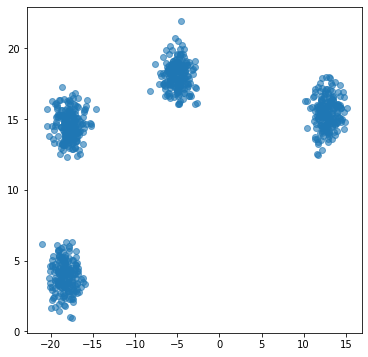

In [132]:
def generate_spheres(nb_clusters, nb_points, nb_dim, radius):
    X = np.zeros((nb_clusters*nb_points, nb_dim))
    y = np.zeros(nb_clusters*nb_points)
    centers = np.zeros((nb_clusters, nb_dim))
    for i in range(nb_clusters):
        # Générer un centre aléatoire
        centers[i] = np.random.uniform(-radius, radius, nb_dim)
        # Générer des points autour du centre
        X[i*nb_points:(i+1)*nb_points, :] = np.random.normal(centers[i], 1, (nb_points, nb_dim))
        # Affecter le label du cluster
        y[i*nb_points:(i+1)*nb_points] = i
    return X, y, centers

X, y, centers = generate_spheres(4, 200, 2, 20)
plt.figure(figsize=(6, 6))
plt.scatter(X[:,0],X[:,1] ,alpha=0.6)
print("centers: ", centers)

# 1.1 C-moyennes floues

In [133]:
def c_moyenne_floue(X, nb_clusters, nb_iter=10, m=2):
    nb_points = X.shape[0]
    nb_dim = X.shape[1]
    # Initialisation des centres des clusters
    ind = np.random.randint(0,X.shape[0], nb_clusters)
    W = X[ind, :]
    eps = 10e-8
    #print("Centres initiaux: \n", W)
    
    # Initialisation des distances entre les points et les centres des clusters
    D = np.zeros((nb_points, nb_clusters))
    for i in range(nb_points):
        for j in range(nb_clusters):
            D[i, j] = np.linalg.norm(X[i] - W[j])

    #  Initialisation des degrés d'appartenance des points aux clusters
    U = np.zeros((nb_points, nb_clusters))
    for i in range(nb_points):
        for j in range(nb_clusters):
            U[i, j] = 1 / (np.sum((D[i, j] / (D[i, :]+eps)) ** (2 / (m - 1)))+eps)

    # Boucle principale
    for t in range(nb_iter):
        # Mise à jour des centres des clusters
        for j in range(nb_clusters):
            W[j] = np.sum(U[:, j] ** m * X.T, axis=1) / np.sum(U[:, j] ** m)
        # Mise à jour des distances
        for i in range(nb_points):
            for j in range(nb_clusters):
                D[i, j] = np.linalg.norm(X[i] - W[j])

        # Mise à jour des degrés d'appartenance
        for i in range(nb_points):
            for j in range(nb_clusters):
                U[i, j] = 1 / np.sum((D[i, j] / D[i, :]) ** (2 / (m - 1)))

    return W, U

Centres finaux: 
 [[-18.32175762   3.91544986]
 [ -5.02282641  18.06336973]
 [-17.79799468  14.56731252]
 [ 12.78123527  15.43485229]]


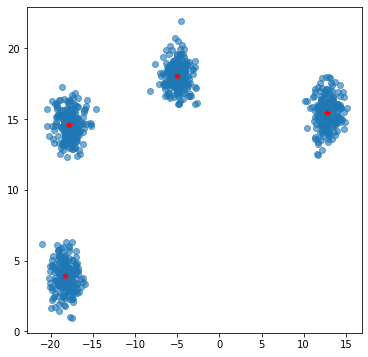

In [134]:
W,U = c_moyenne_floue(X, 4, nb_iter = 100, m=2)
print("Centres finaux: \n", W)

# Affichage des données
plt.figure(figsize=(6, 6))
plt.scatter(X[:,0],X[:,1] ,alpha=0.6)
plt.plot(W[:, 0], W[:, 1], 'r*')
plt.show()

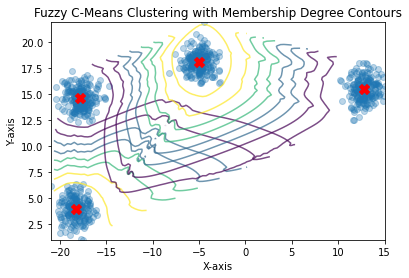

In [135]:
def plot_fuzzy_cmeans_contours(X, W, U, figsize=(8, 8), resolution=100):
    """
    Plots the data points, centroids of the fuzzy c-means clusters, and the membership degree contours for each cluster.

    :param X: Data points, numpy array of shape (n_samples, n_features).
    :param W: Centroids of clusters, numpy array of shape (n_clusters, n_features).
    :param U: Membership degrees, numpy array of shape (n_samples, n_clusters).
    :param figsize: Size of the figure (width, height) in inches.
    :param resolution: Resolution for the meshgrid used in contour plots.
    """
    #plt.figure(figsize=figsize)

    # Create a meshgrid for the contour plots
    x_min, y_min = np.min(X, axis=0)
    x_max, y_max = np.max(X, axis=0)
    x = np.linspace(x_min, x_max, resolution)
    y = np.linspace(y_min, y_max, resolution)
    X_mesh, Y_mesh = np.meshgrid(x, y)

    # Create a custom colormap
    cmap = ListedColormap(plt.cm.viridis(np.linspace(0, 1, W.shape[0])))

    # Plot contours for each cluster
    for j in range(W.shape[1]):
        # Interpolate membership degrees for cluster j
        Z = griddata(X, U[:, j], (X_mesh, Y_mesh), method='cubic')

        # Plot the membership degree contours for cluster j
        contour = plt.contour(X_mesh, Y_mesh, Z, levels=np.linspace(0, 1, 10), cmap=cmap, alpha=0.7)

    # Plot the data points and the centroids
    plt.scatter(X[:, 0], X[:, 1], alpha =0.3)
    plt.scatter(W[:, 0], W[:, 1], c='red', s=100, marker='X')

    # Labeling the plot
    plt.title("Fuzzy C-Means Clustering with Membership Degree Contours")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")

# Example usage
# Assuming W and U are the outputs of your fuzzy c-means function for dataset X
plot_fuzzy_cmeans_contours(X, W, U)
plt.show()


# 1.2 C-moyenne floue possibiliste

In [136]:
nb_clusters = 4

def pcm(X, nb_clusters, W=None,eta = np.ones((nb_clusters))*2.5, nb_iter=100, m=2):
    """
    Possibilist c-means clustering algorithm.

    :param X: Data points, numpy array of shape (n_samples, n_features).
    :param nb_clusters: The number of clusters to form.
    :param eta: Typicality parameters for each cluster, numpy array of shape (nb_clusters,).
    :param nb_iter: Number of iterations to run.
    :param m: Fuzziness parameter.
    :return: Tuple (W, U) where W is an array of centroids and U is the matrix of typicalities.
    """
    nb_points, nb_dim = X.shape

    # Initialize cluster centers randomly from data points
    indices = np.random.choice(nb_points, nb_clusters, replace=False)
    if W is None:
        W = X[indices, :]
    #W = X[indices, :]

    # Initialize the matrix of typicalities
    U = np.random.rand(nb_points, nb_clusters)
    U = U / np.sum(U, axis=1, keepdims=True)

    for iteration in range(nb_iter):
        # Update typicalities U
        for i in range(nb_points):
            for j in range(nb_clusters):
                dist = np.linalg.norm(X[i] - W[j])
                U[i, j] = 1 / (1 + (dist / eta[j]) ** (2 / (m - 1)))

        # Update cluster centers W
        for j in range(nb_clusters):
            numerator = np.sum(U[:, j] ** m * X.T, axis=1)
            denominator = np.sum(U[:, j] ** m)
            W[j] = numerator / denominator

        # Optional: Implement convergence check to break the loop if clusters do not change significantly

    return W, U

nb_clusters = 4
eta = np.array([1.5 for _ in range(nb_clusters)])  # Define eta for each cluster
W, U = pcm(X, nb_clusters=nb_clusters,eta=eta)
print("Centres finaux: \n", W)
print("Typicalités finales: \n", U)

Centres finaux: 
 [[ -5.08883909  18.0473302 ]
 [-18.35483314   4.03055754]
 [ -5.08883909  18.0473302 ]
 [-17.74658852  14.43713556]]
Typicalités finales: 
 [[0.44744526 0.00512869 0.44744526 0.01085268]
 [0.96122765 0.00619213 0.96122765 0.01326475]
 [0.40673304 0.00508193 0.40673304 0.00995788]
 ...
 [0.00711342 0.00200694 0.00711342 0.00242574]
 [0.00724528 0.00215906 0.00724528 0.00251572]
 [0.00709135 0.00214516 0.00709135 0.00248857]]


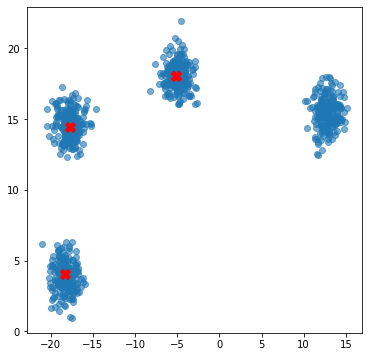

In [137]:
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.6)
plt.scatter(W[:, 0], W[:, 1], c='red', s=100, marker='X')
plt.show()

# 2. Comparaisons des resultats sur differents algorithmes de clustering

## Explications pour la partie 2

Nous avons testé les différents algo de clustering sur des données artificielles de gaussiennes en faisant varier le nombre de clusters.

L'algorithme K-means, lorsque le nombre de clusters définit = le nombre de clusters réels, réussi à identifier les bons clusters (cf 4 clusters). Lorsque le nombre définit de clusters est inférieur au nombre réel, il attribue les données au cluster le plus proche en placant son centroide entre les deux clusters (cf 2 clusters) et lorsque le nombre de cluster définit > nombre de clusters, il redécoupe les clusters réels (cf 7 clusters).

L'algorithme GMM fonctionne sur le meme principe mais en definissant une probabilité d'appartenance.

L'algorithme Fuzzy c-mean et possibilist fuzzy c-mean ne définissent pas le degré d'appartenance de manière sphérique contrairement à GMM.  A partir de nos experiences, on ne voit pas de différence significative entre les deux algorithmes, nous mettrons en evidence les différences lors des questions 4 et 5.

Les algorithmes clustering spectral et hierarchique fonctionnent bien sur ce type données si le nombre de clusters definit est équivalent au nombre de clusters réels. 

Pour DBSCAN, on ne definit pas de nombre de clusters, c'est l'algorithme qui s'adapte aux données. Cependant il existe des hyper-parametres à régler et l'algorithme va être tres sensible à ceux ci. Ce type de clustering sur des gaussiennes à moins de sens que des algorithmes comme K-mean, GMM, fuzzy c-mean , possibilistic fuzzy c-mean.





centers:  [[10.02176655  9.8567932 ]
 [ 1.03081347  8.72406952]
 [ 9.41913553 19.68299058]
 [ 4.75740651 -8.68456361]]


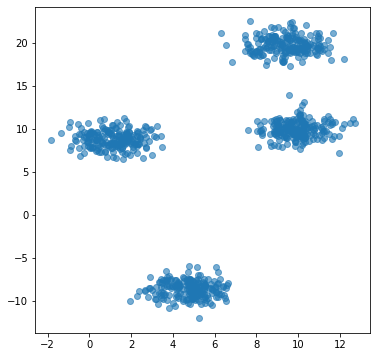

In [138]:
X, y, centers = generate_spheres(4, 200, 2, 20)
plt.figure(figsize=(6, 6))
plt.scatter(X[:,0],X[:,1] ,alpha=0.6)
print("centers: ", centers)
plt.show()

## 2.1 Algorithme K-Means

In [139]:
km = KMeans(n_clusters=4, n_init=1, max_iter=100, tol=0.0001, random_state=0)
km.fit(X)
print("Inertia: ", km.inertia_)
print("Centroides: \n", km.cluster_centers_)
print("Nombre d'itérations: ", km.n_iter_)

Inertia:  1573.2281045863956
Centroides: 
 [[ 9.40898186 19.72169572]
 [ 4.73914292 -8.63854317]
 [ 1.11831158  8.7888885 ]
 [ 9.9402475   9.94568001]]
Nombre d'itérations:  2


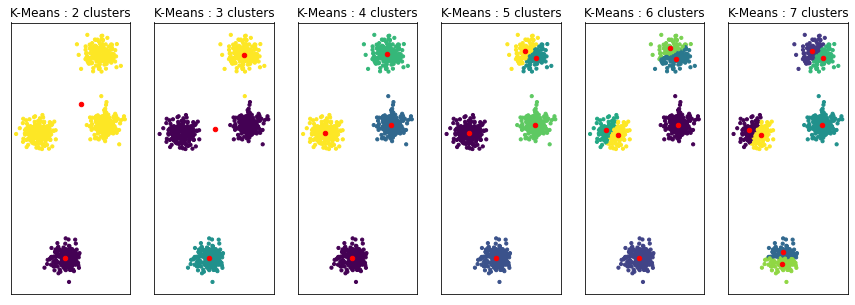

In [140]:
# Algorithms to compare
n_clusters_list = [2, 3, 4, 5, 6, 7]
random_state = 0
clustering_algorithms = {
    "K-Means": KMeans,
}

# Make subplots for each variant
fig, axs = plt.subplots(1, len(n_clusters_list), figsize=(15, 5))

for j, n_clusters in enumerate(n_clusters_list):
    for i, (algorithm_name, Algorithm) in enumerate(clustering_algorithms.items()):
        algo = Algorithm(n_clusters=n_clusters, n_init=10, max_iter=300, tol=0.0001)
        algo.fit(X)
        centers = algo.cluster_centers_

        axs[j].scatter(X[:, 0], X[:, 1], s=10, c=algo.labels_)
        axs[j].scatter(centers[:, 0], centers[:, 1], c="r", s=20)

        axs[j].set_title(f"{algorithm_name} : {n_clusters} clusters")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs:
    ax.label_outer()
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


## 2.2 Algorithme GMM

Fonction d'affichage pour l'algorithme Gaussian Mixture avec contours de niveau:

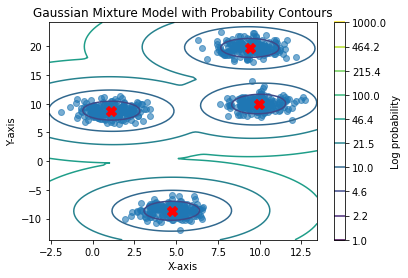

In [141]:
gm = GaussianMixture(n_components=4, n_init=10, max_iter=100, tol=0.0001, random_state=0)
gm.fit(X)

def plot_gmm_clusters_with_contours(gm, X, figsize=(8, 8), resolution=100):
    """
    Plots the data points, centroids of the GMM clusters, and the probability contours.

    :param gm: Fitted GaussianMixture object.
    :param X: Data points, numpy array of shape (n_samples, n_features).
    :param figsize: Size of the figure (width, height) in inches.
    :param resolution: Resolution for the meshgrid used in contour plots.
    """
    #plt.figure(figsize=figsize)

    # Plot the data points and the centroids
    plt.scatter(X[:, 0], X[:, 1], alpha=0.6)
    plt.scatter(gm.means_[:, 0], gm.means_[:, 1], c='red', s=100, marker='X')

    # Create a meshgrid for the contour plots
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], resolution)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], resolution)
    X_mesh, Y_mesh = np.meshgrid(x, y)
    XX = np.array([X_mesh.ravel(), Y_mesh.ravel()]).T

    # Calculate the log probabilities for each point in the meshgrid
    Z = -gm.score_samples(XX)
    Z = Z.reshape(X_mesh.shape)

    # Plot the probability contours
    plt.contour(X_mesh, Y_mesh, Z, levels=np.logspace(0, 3, 10), norm=LogNorm(vmin=1.0, vmax=1000.0), cmap='viridis')

    # Labeling the plot
    plt.title("Gaussian Mixture Model with Probability Contours")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.colorbar(label='Log probability')

    #plt.show()

# Example usage
# Assuming gm is your fitted GaussianMixture model and X is your data
plot_gmm_clusters_with_contours(gm, X)


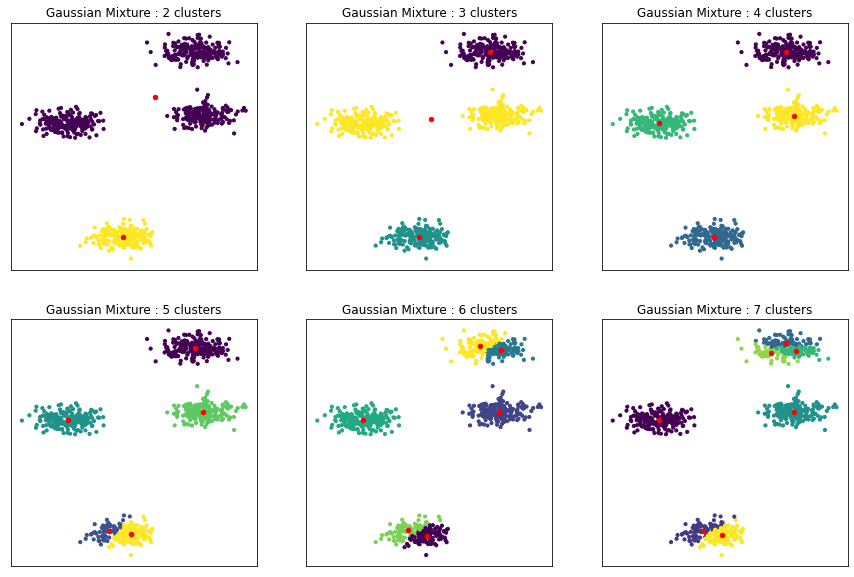

In [142]:
# Algorithms to compare
n_components_list = [2, 3, 4, 5, 6, 7]
random_state = 0
clustering_algorithms = {
    "Gaussian Mixture": GaussianMixture,
}

# Calculate the number of rows needed for the subplots
num_rows = len(n_components_list) // 3 + (len(n_components_list) % 3 > 0)

# Make subplots with 3 graphs per line
fig, axs = plt.subplots(
    num_rows, 3, figsize=(15, 5 * num_rows)
)

for i, (algorithm_name, Algorithm) in enumerate(clustering_algorithms.items()):
    for j, n in enumerate(n_components_list):
        gm = Algorithm(n_components=n, n_init=10, max_iter=100, tol=0.0001, random_state=random_state)
        gm.fit(X)
        means = gm.means_

        row = j // 3
        col = j % 3

        axs[row, col].scatter(X[:, 0], X[:, 1], s=10, c=gm.predict(X))
        axs[row, col].scatter(means[:, 0], means[:, 1], c="r", s=20)

        axs[row, col].set_title(f"{algorithm_name} : {n} clusters")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

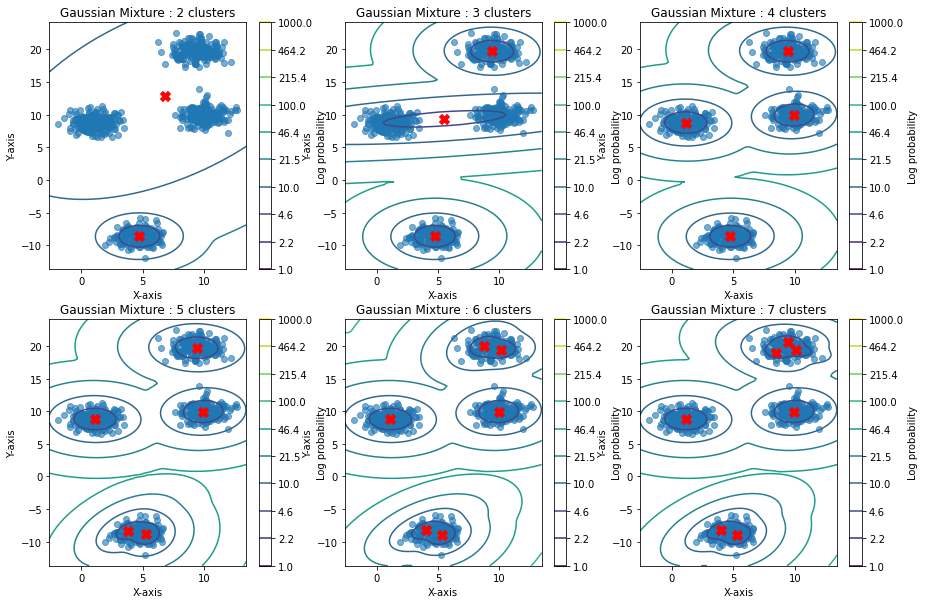

In [143]:
# Algorithms to compare
n_components_list = [2, 3, 4, 5, 6, 7]
random_state = 0
clustering_algorithms = {
    "Gaussian Mixture": GaussianMixture,
}

# Calculate the number of rows needed for the subplots
num_rows = len(n_components_list) // 3 + (len(n_components_list) % 3 > 0)

for i, (algorithm_name, Algorithm) in enumerate(clustering_algorithms.items()):
    plt.figure(figsize=(15, 5 * num_rows))
    for j, n in enumerate(n_components_list):

        gm = Algorithm(n_components=n, n_init=10, max_iter=100, tol=0.0001, random_state=random_state)
        gm.fit(X)
        means = gm.means_

        # Plot the contours
        plt.subplot(num_rows, 3, j + 1)
        plot_gmm_clusters_with_contours(gm, X)
        plt.title(f"{algorithm_name} : {n} clusters")



## 2.3 Algorithme c-moyennes floues

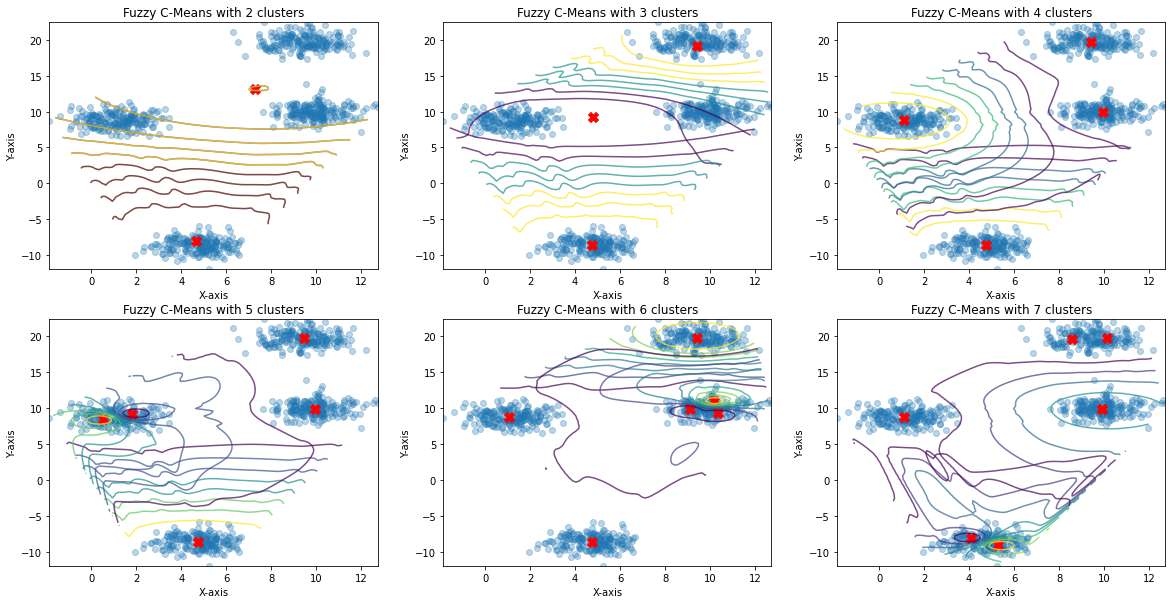

In [144]:
# Paramètres de l'algorithme fuzzy c-means
nb_iter = 10
m = 2

# Liste des valeurs de nb_clusters à tester
nb_clusters_list = [2, 3, 4, 5, 6, 7]
plt.figure(figsize=(20, 10))

# Afficher les résultats pour chaque valeur de nb_clusters
for nb_clusters in nb_clusters_list:
    # Application de l'algorithme fuzzy c-means
    W, U = c_moyenne_floue(X, nb_clusters, nb_iter, m)

    # Affichage des contours et des centres obtenus
    plt.subplot(2, 3, nb_clusters - 1)
    plot_fuzzy_cmeans_contours(X, W, U)
    plt.title(f"Fuzzy C-Means with {nb_clusters} clusters")
    

plt.show()

## 2.4 Algorithme c-moyennes floues possibilistes

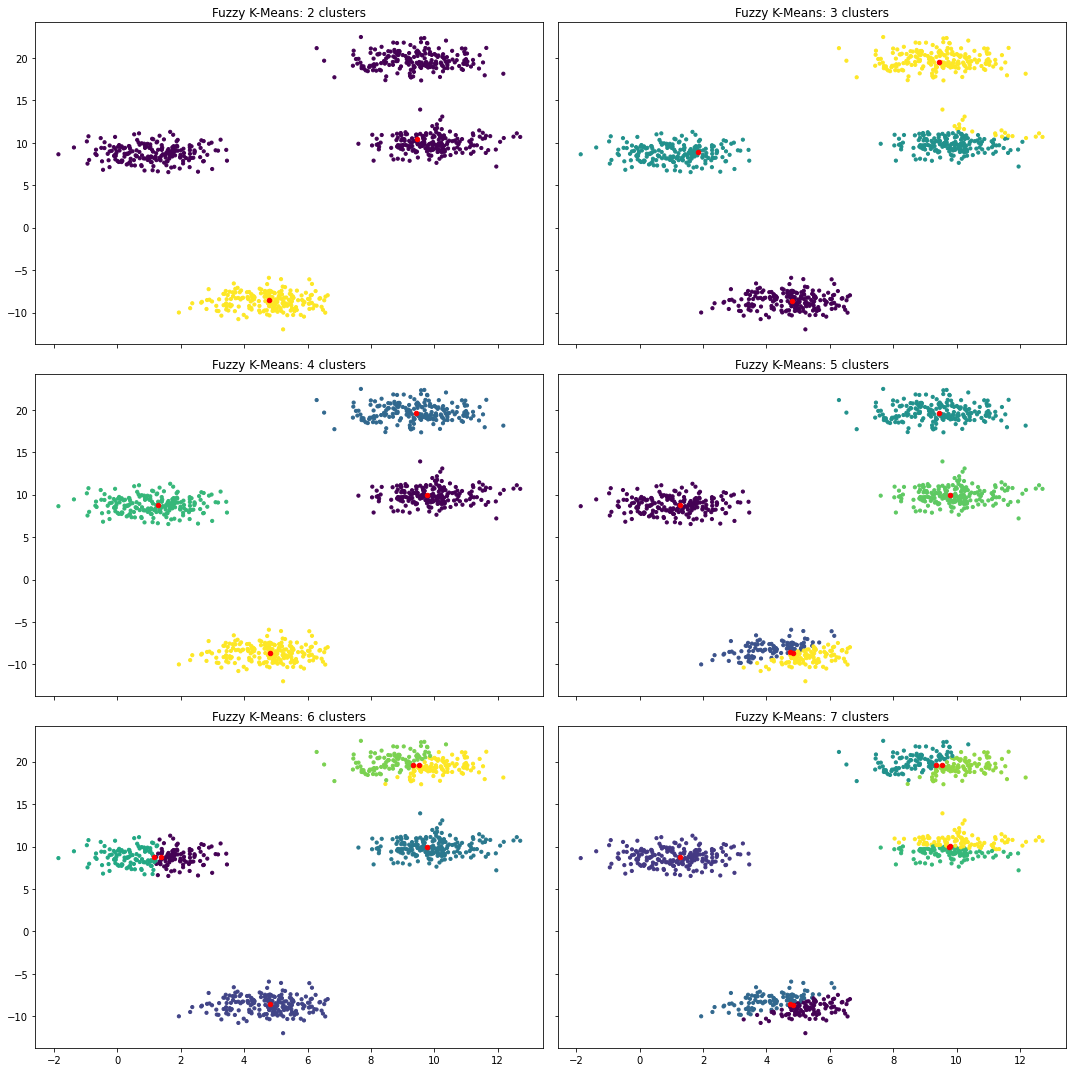

In [145]:
# Liste des valeurs de nb_clusters à tester
nb_clusters_list = [2, 3, 4, 5, 6, 7]

# Calculate the number of rows needed for the subplots
num_rows = len(nb_clusters_list) // 2 + (len(nb_clusters_list) % 2 > 0)

fig, axs = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))

for i, nb_clusters in enumerate(nb_clusters_list):
    # Parameters for fuzzy k-means
    eta = np.ones((nb_clusters))*2.5
    W1,U1 = c_moyenne_floue(X, nb_clusters, nb_iter = 100, m=2)

    # Apply fuzzy k-means
    final_centers, membership_degrees = pcm(X, eta=eta, W=W1, nb_clusters=nb_clusters, nb_iter = 2, m=2)

    # Plot the results
    row = i // 2
    col = i % 2
    axs[row, col].scatter(X[:, 0], X[:, 1], s=10, c=np.argmax(membership_degrees, axis=1))
    axs[row, col].scatter(final_centers[:, 0], final_centers[:, 1], c="r", s=20)
    axs[row, col].set_title(f"Fuzzy K-Means: {nb_clusters} clusters")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.tight_layout()
plt.show()

#### Avec les lignes de niveaux des fonctions d’affectation pondérée

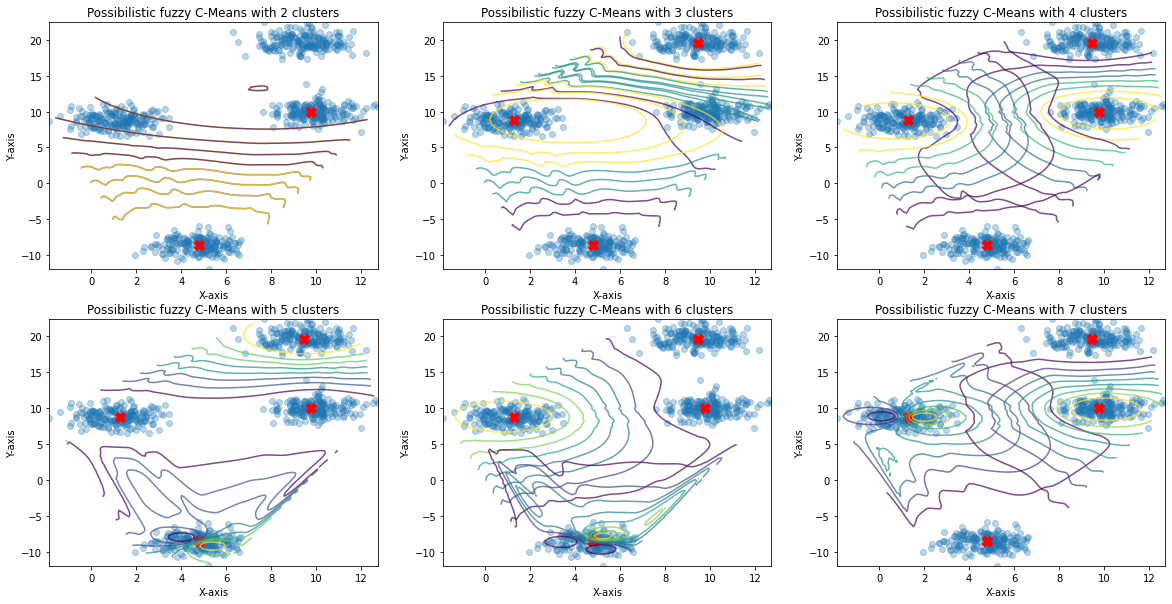

In [146]:
# Paramètres de l'algorithme fuzzy c-means
nb_iter = 10
m = 2

# Liste des valeurs de nb_clusters à tester
nb_clusters_list = [2, 3, 4, 5, 6, 7]
plt.figure(figsize=(20, 10))
# Afficher les résultats pour chaque valeur de nb_clusters
for nb_clusters in nb_clusters_list:
    # Application de l'algorithme fuzzy c-means
    eta = np.ones((nb_clusters))*2.5
    W1,U1 = c_moyenne_floue(X, nb_clusters, nb_iter = 100, m=2)

    # Apply fuzzy k-means
    #W, U = c_moyenne_floue_possibiliste(X, W1, eta, nb_clusters=nb_clusters, nb_iter = 2, m=2)
    W, U = pcm(X, W=W1, nb_clusters=nb_clusters, eta=eta)
    # Affichage des contours et des centres obtenus
    plt.subplot(2, 3, nb_clusters - 1)
    plot_fuzzy_cmeans_contours(X, W1, U1)
    plt.title(f"Possibilistic fuzzy C-Means with {nb_clusters} clusters")

plt.show()

## 2.5 Clustering hiérarchique 

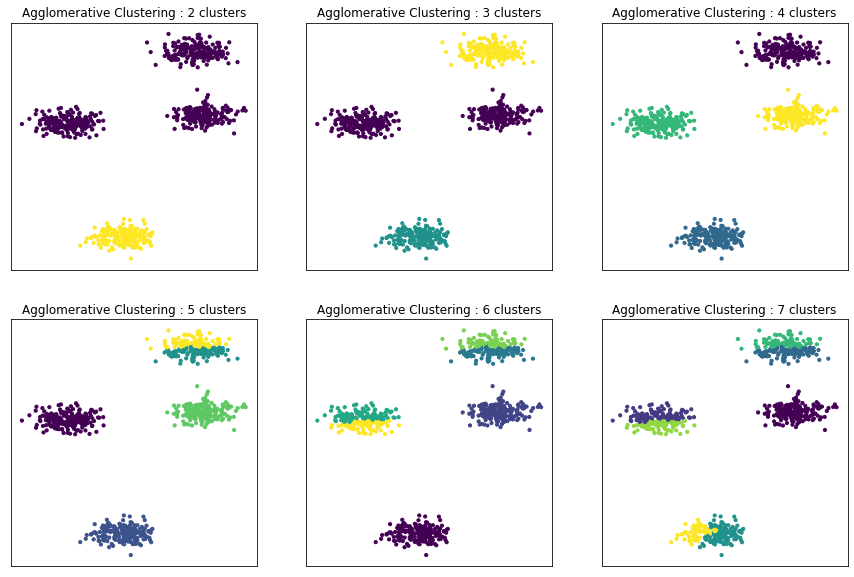

In [147]:
# Algorithms to compare
n_clusters_list = [2, 3, 4, 5, 6, 7]
linkage_method = 'ward'
distance_threshold = None
random_state = 0
clustering_algorithms = {
    "Agglomerative Clustering": AgglomerativeClustering,
}

# Calculate the number of rows needed for the subplots
num_rows = len(n_clusters_list) // 3 + (len(n_clusters_list) % 3 > 0)

# Make subplots with 3 graphs per line
fig, axs = plt.subplots(
    num_rows, 3, figsize=(15, 5 * num_rows)
)

for i, (algorithm_name, Algorithm) in enumerate(clustering_algorithms.items()):
    for j, n_clusters in enumerate(n_clusters_list):
        agglomerative = Algorithm(n_clusters=n_clusters, linkage=linkage_method, distance_threshold=distance_threshold)
        agglomerative.fit(X)

        row = j // 3
        col = j % 3

        axs[row, col].scatter(X[:, 0], X[:, 1], s=10, c=agglomerative.labels_)

        axs[row, col].set_title(f"{algorithm_name} : {n_clusters} clusters")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


## 2.6 Clustering spectral

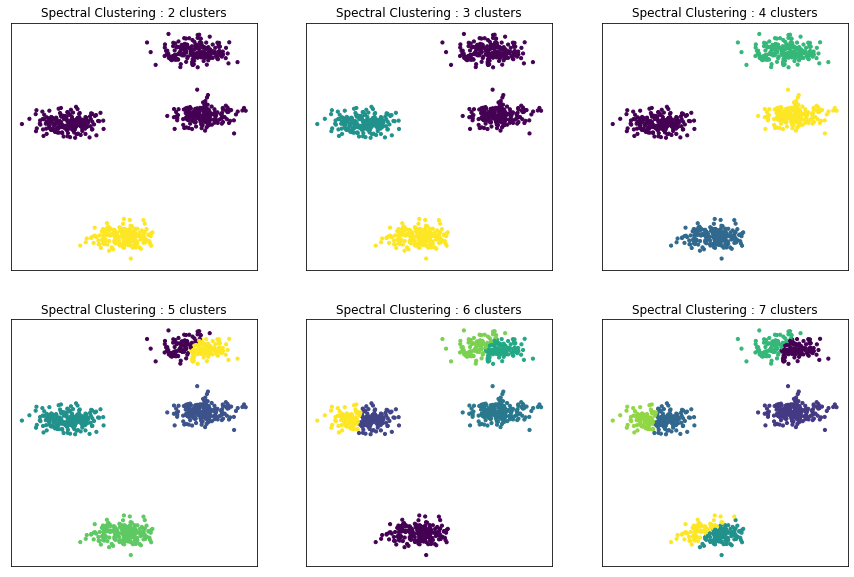

In [148]:
# Algorithms to compare
n_clusters_list = [2, 3, 4, 5, 6, 7]
random_state = None
n_init = 10
gamma = 1.0
affinity = 'rbf'
degree = 3
coef0 = 1
clustering_algorithms = {
    "Spectral Clustering": SpectralClustering,
}

# Calculate the number of rows needed for the subplots
num_rows = len(n_clusters_list) // 3 + (len(n_clusters_list) % 3 > 0)

# Make subplots with 3 graphs per line
fig, axs = plt.subplots(
    num_rows, 3, figsize=(15, 5 * num_rows)
)

for i, (algorithm_name, Algorithm) in enumerate(clustering_algorithms.items()):
    for j, n_clusters in enumerate(n_clusters_list):
        spectral_clustering = Algorithm(
            n_clusters=n_clusters,
            random_state=random_state,
            n_init=n_init,
            gamma=gamma,
            affinity=affinity,
            degree=degree,
            coef0=coef0
        )
        spectral_clustering.fit(X)

        row = j // 3
        col = j % 3

        axs[row, col].scatter(X[:, 0], X[:, 1], s=10, c=spectral_clustering.labels_)

        axs[row, col].set_title(f"{algorithm_name} : {n_clusters} clusters")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


## 2.7 DBSCAN

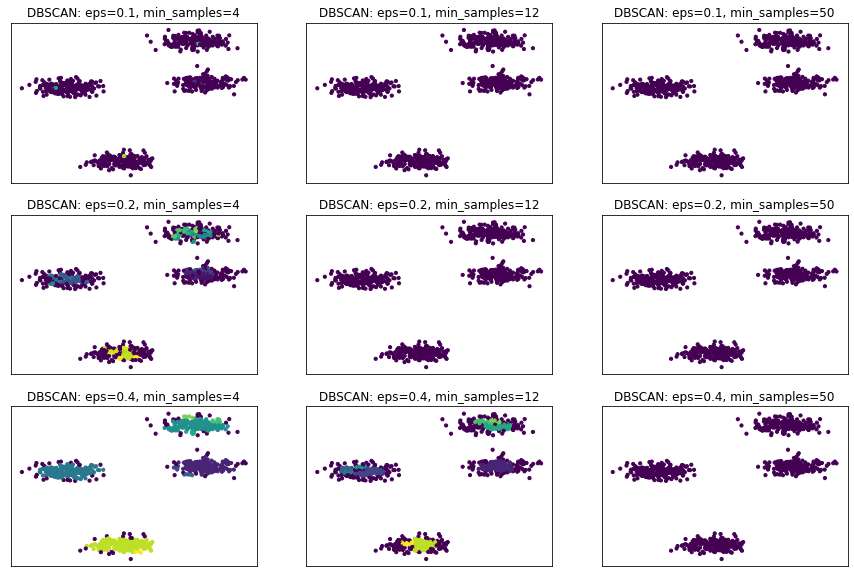

In [149]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Parameters to vary
eps_values = [0.1, 0.2, 0.4]
min_samples_values = [4, 12, 50]

# Create a grid of subplots
fig, axs = plt.subplots(len(eps_values), len(min_samples_values), figsize=(15, 10))

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(X)

        axs[i, j].scatter(X[:, 0], X[:, 1], s=10, c=dbscan.labels_, cmap='viridis')
        axs[i, j].set_title(f"DBSCAN: eps={eps}, min_samples={min_samples}")

# Set common labels and hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


# 3. Comparaison des résultats obtenus sur les données halfmoons (clusters non gaussiens)

## Explication: 
Il n'est pas facile de réaliser du clustering sur les demi lunes, en effet les algorithme de type K-mean, GMM , fuzzy c-mean et possibilistic c-mean vont etre mis en défaut car ils correspondent à des clusters gaussiens ou spheriques. En effet sur les figures ci dessus, on peut voir que ces algo n'arrivent pas à definir correctement les clusters. Et on peut voir avec les lignes de niveaux qu'ils ne s'adaptent pas aux données et font comme si c'etait des clusters gaussiens.

Possibilistic c-mean a tendance à rassembler aux memes endroits les centres des clusters.

Les clustering hierarchique et spectral sont eux aussi mis en defaut.

DBSCAN quant à lui est sensible aux hyperparametres (eps et min_sample_value) cependant il est possible grace à cet algo d'obtenir un clustering correct sur les données half moon.

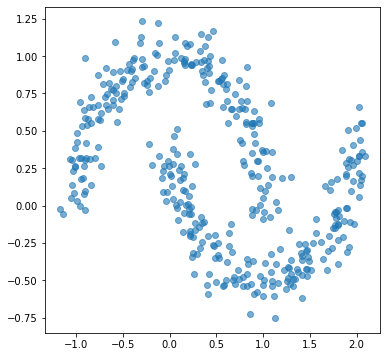

In [150]:
X, y = make_moons(n_samples=400, shuffle=True, noise=0.1)
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.6)

## 3.1 Algorithme c-moyennes floues

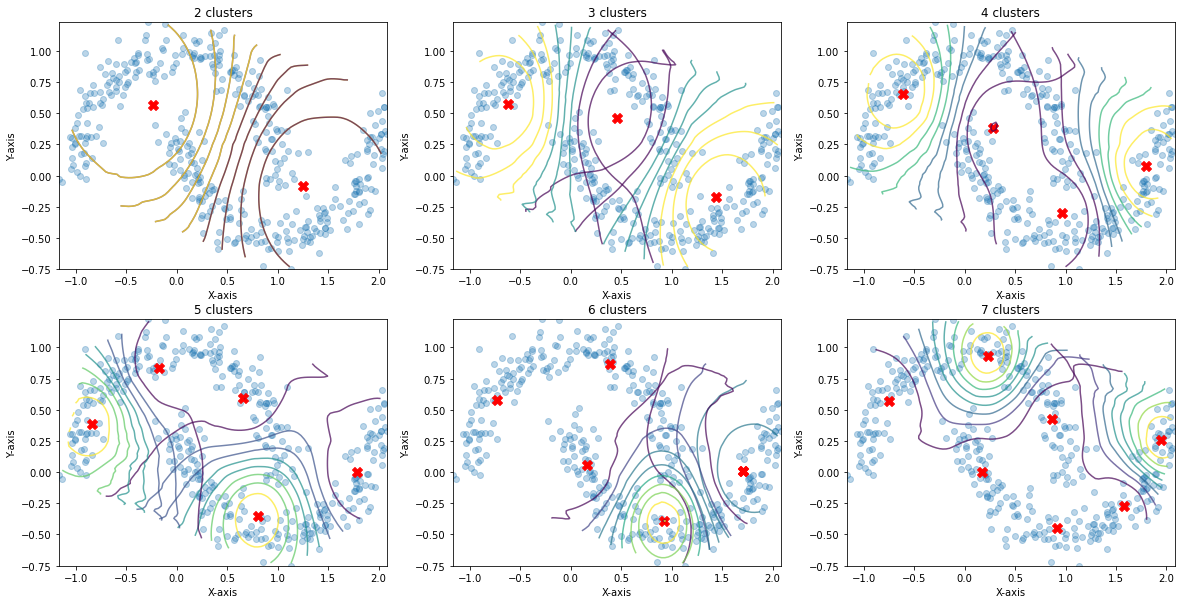

In [151]:
# Paramètres de l'algorithme fuzzy c-means
nb_iter = 10
m = 2

# Liste des valeurs de nb_clusters à tester
nb_clusters_list = [2, 3, 4, 5, 6, 7]
plt.figure(figsize=(20, 10))
# Afficher les résultats pour chaque valeur de nb_clusters
for nb_clusters in nb_clusters_list:
    # Application de l'algorithme fuzzy c-means
    W, U = c_moyenne_floue(X, nb_clusters, nb_iter, m)

    # Affichage des contours et des centres obtenus
    plt.subplot(2, 3, nb_clusters - 1)
    plot_fuzzy_cmeans_contours(X, W, U)
    plt.title(f"{nb_clusters} clusters")

plt.show()

## 3.2 Algorithme c-moyennes floues possibilistes

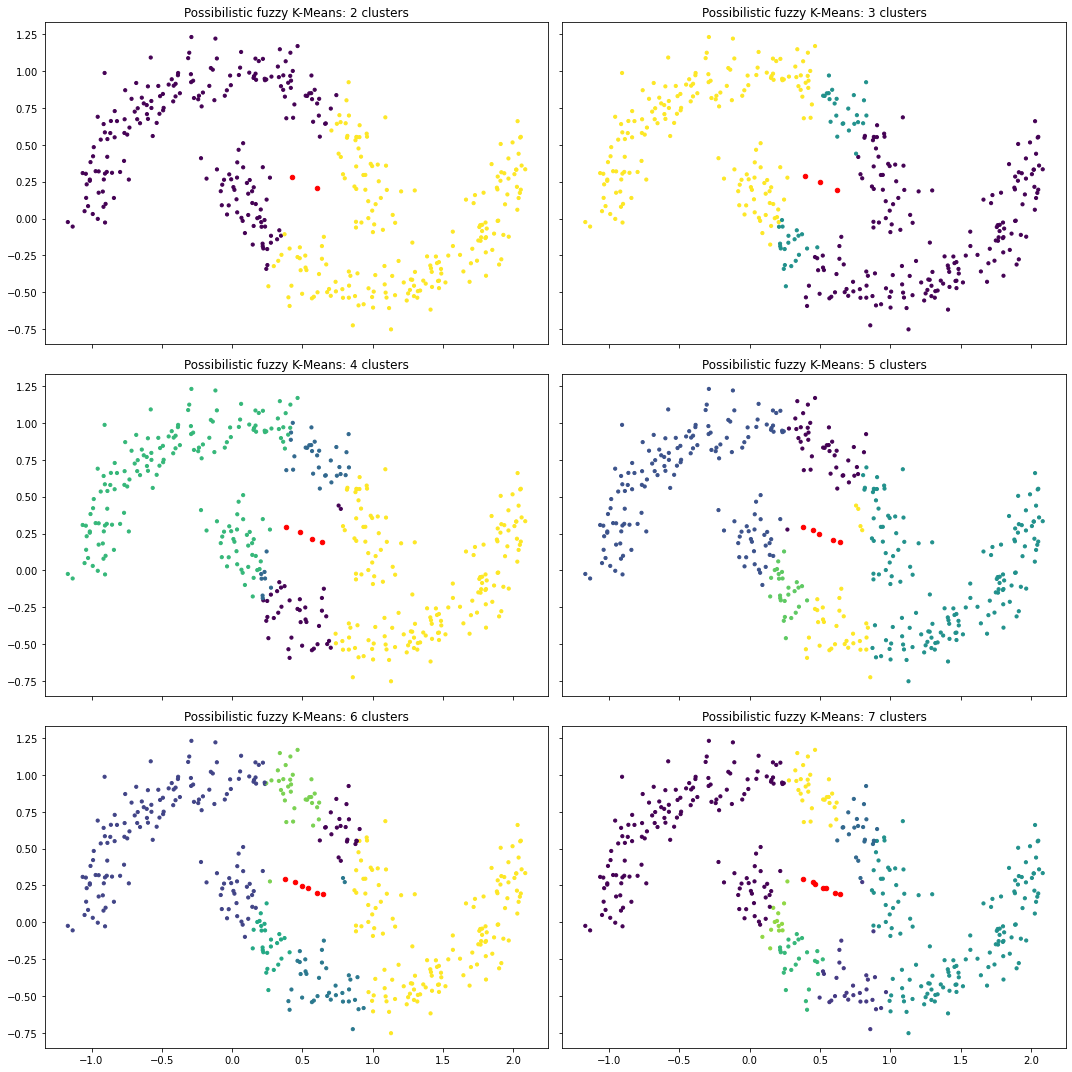

In [152]:
# Liste des valeurs de nb_clusters à tester
nb_clusters_list = [2, 3, 4, 5, 6, 7]

# Calculate the number of rows needed for the subplots
num_rows = len(nb_clusters_list) // 2 + (len(nb_clusters_list) % 2 > 0)

fig, axs = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))

for i, nb_clusters in enumerate(nb_clusters_list):
    # Parameters for fuzzy k-means
    eta = np.ones((nb_clusters))*2.5
    W1,U1 = c_moyenne_floue(X, nb_clusters, nb_iter = 10, m=2)

    # Apply fuzzy k-means
    final_centers, membership_degrees = pcm(X, eta=eta, W=W1, nb_clusters=nb_clusters, nb_iter = 2, m=2)

    # Plot the results
    row = i // 2
    col = i % 2
    axs[row, col].scatter(X[:, 0], X[:, 1], s=10, c=np.argmax(membership_degrees, axis=1))
    axs[row, col].scatter(final_centers[:, 0], final_centers[:, 1], c="r", s=20)
    axs[row, col].set_title(f"Possibilistic fuzzy K-Means: {nb_clusters} clusters")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.tight_layout()
plt.show()

#### Avec les lignes de niveaux des fonctions d’affectation pondérée

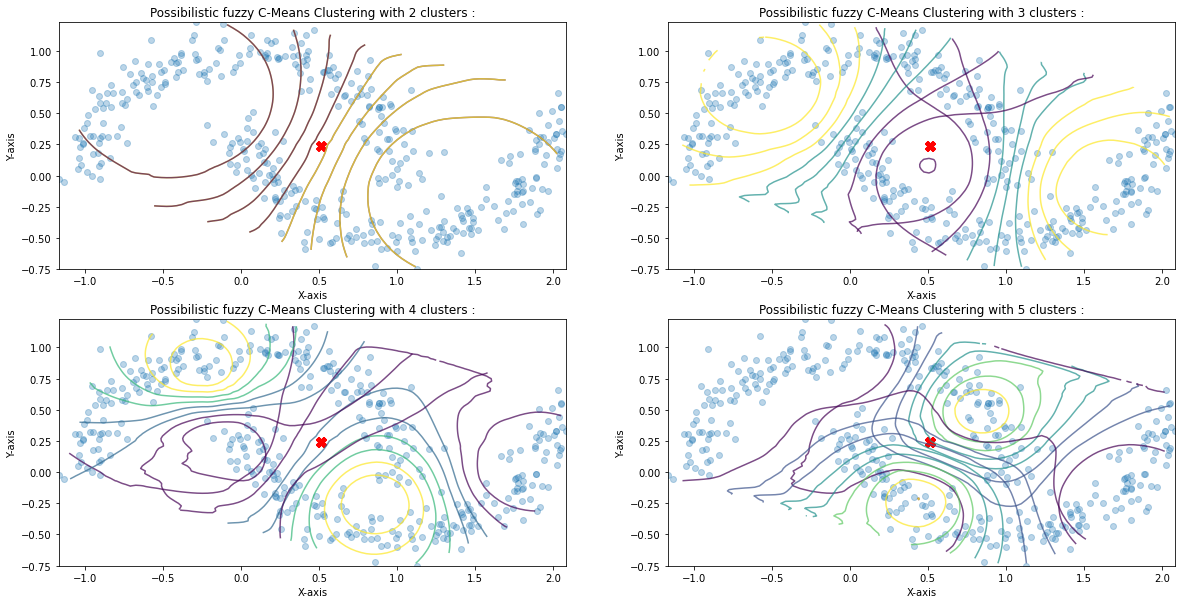

In [153]:
# Paramètres de l'algorithme fuzzy c-means
nb_iter = 10
m = 2

# Liste des valeurs de nb_clusters à tester
nb_clusters_list = [2, 3, 4, 5]
plt.figure(figsize=(20,10))   
# Afficher les résultats pour chaque valeur de nb_clusters
for nb_clusters in nb_clusters_list:
    # Application de l'algorithme fuzzy c-means
    eta = np.ones((nb_clusters))*2.5
    W1,U1 = c_moyenne_floue(X, nb_clusters, nb_iter = 10, m=2)

    # Apply fuzzy k-means
    #W, U = c_moyenne_floue_possibiliste(X, W1, eta, nb_clusters=nb_clusters, nb_iter = 2, m=2)
    W, U = pcm(X, W=W1, nb_clusters=nb_clusters, eta=eta)
    # Affichage des contours et des centres obtenus
    plt.subplot(2,2,nb_clusters-1)
    plot_fuzzy_cmeans_contours(X, W1, U1)
    plt.title("Possibilistic fuzzy C-Means Clustering with {} clusters :".format(nb_clusters))

plt.show()

## 3.3 Algorithme GMM 

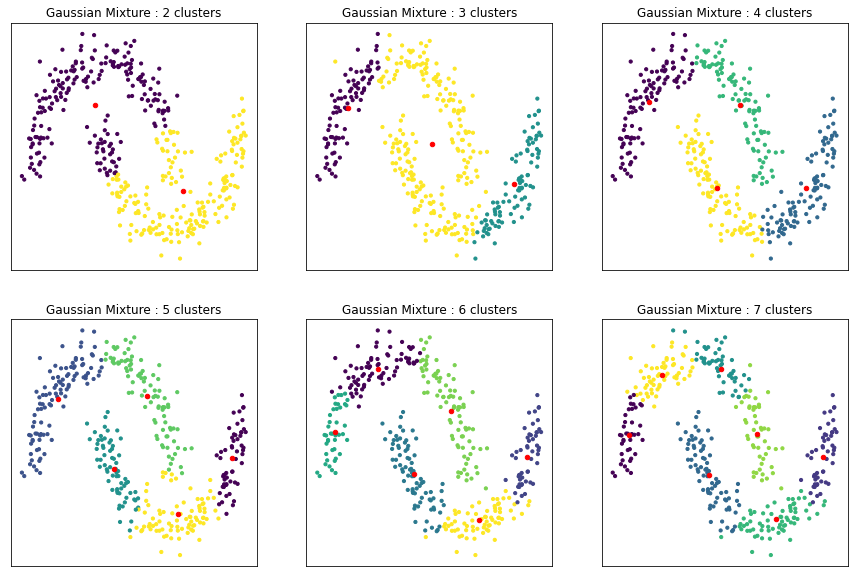

In [154]:
# Algorithms to compare
n_components_list = [2, 3, 4, 5, 6, 7]
random_state = 0
clustering_algorithms = {
    "Gaussian Mixture": GaussianMixture,
}

# Calculate the number of rows needed for the subplots
num_rows = len(n_components_list) // 3 + (len(n_components_list) % 3 > 0)

# Make subplots with 3 graphs per line
fig, axs = plt.subplots(
    num_rows, 3, figsize=(15, 5 * num_rows)
)

for i, (algorithm_name, Algorithm) in enumerate(clustering_algorithms.items()):
    for j, n in enumerate(n_components_list):
        gm = Algorithm(n_components=n, n_init=10, max_iter=100, tol=0.0001, random_state=random_state)
        gm.fit(X)
        means = gm.means_

        row = j // 3
        col = j % 3

        axs[row, col].scatter(X[:, 0], X[:, 1], s=10, c=gm.predict(X))
        axs[row, col].scatter(means[:, 0], means[:, 1], c="r", s=20)

        axs[row, col].set_title(f"{algorithm_name} : {n} clusters")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


#### Avec les lignes de niveaux des fonctions d’affectation pondérée

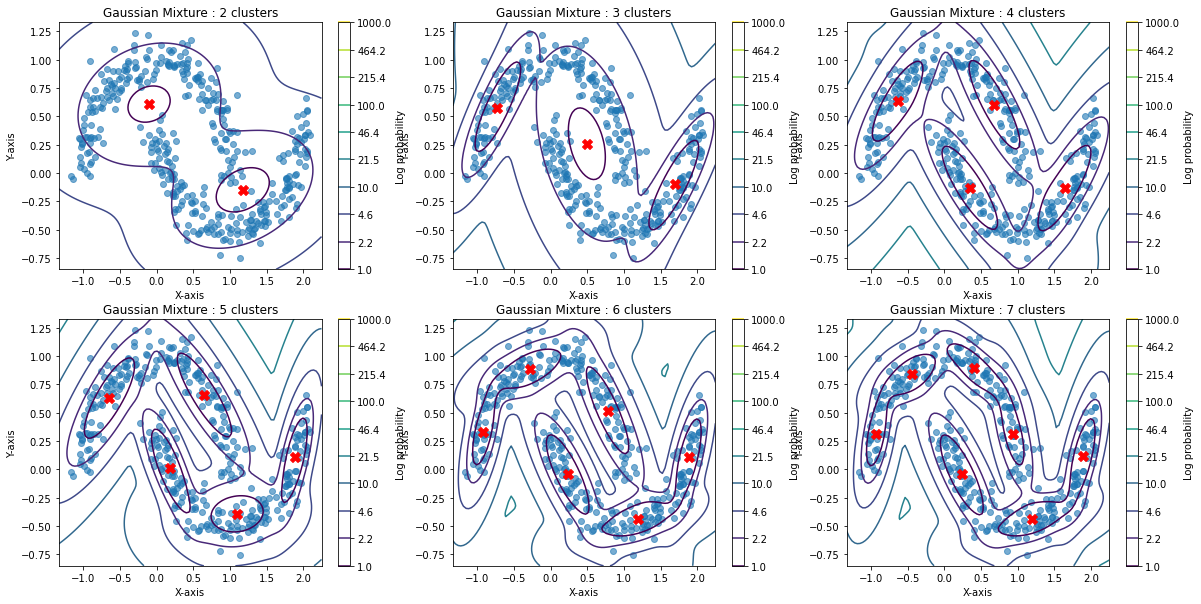

In [155]:
# Algorithms to compare
n_components_list = [2, 3, 4, 5, 6, 7]
random_state = 0
clustering_algorithms = {
    "Gaussian Mixture": GaussianMixture,
}

# Calculate the number of rows needed for the subplots
num_rows = len(n_components_list) // 3 + (len(n_components_list) % 3 > 0)

for i, (algorithm_name, Algorithm) in enumerate(clustering_algorithms.items()):
    plt.figure(figsize=(20, 10))
    for j, n in enumerate(n_components_list):
        gm = Algorithm(n_components=n, n_init=10, max_iter=100, tol=0.0001, random_state=random_state)
        gm.fit(X)
        means = gm.means_

        # Plot the contours
        plt.subplot(num_rows, 3, j + 1)
        plot_gmm_clusters_with_contours(gm, X)
        plt.title(f"{algorithm_name} : {n} clusters")



## 3.4 Clustering hiérarchique

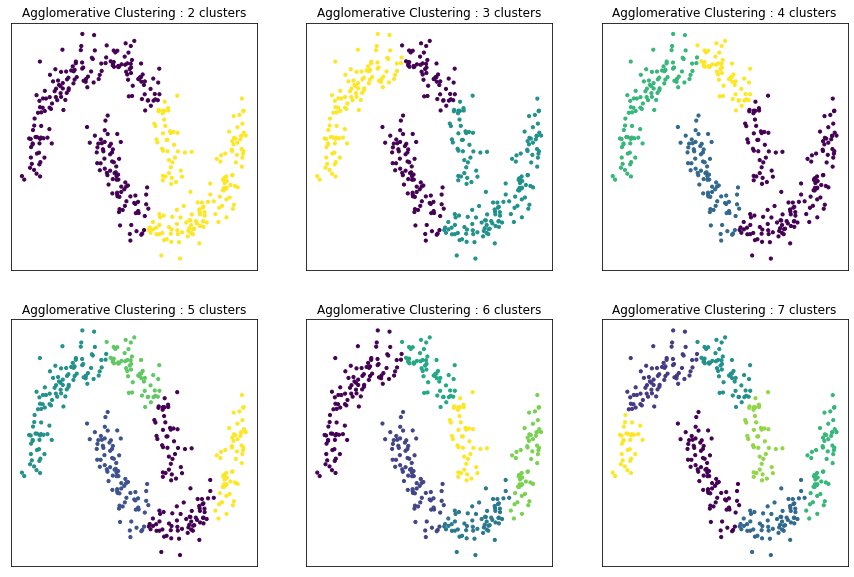

In [156]:
# Algorithms to compare
n_clusters_list = [2, 3, 4, 5, 6, 7]
linkage_method = 'ward'
distance_threshold = None
random_state = 0
clustering_algorithms = {
    "Agglomerative Clustering": AgglomerativeClustering,
}

# Calculate the number of rows needed for the subplots
num_rows = len(n_clusters_list) // 3 + (len(n_clusters_list) % 3 > 0)

# Make subplots with 3 graphs per line
fig, axs = plt.subplots(
    num_rows, 3, figsize=(15, 5 * num_rows)
)

for i, (algorithm_name, Algorithm) in enumerate(clustering_algorithms.items()):
    for j, n_clusters in enumerate(n_clusters_list):
        agglomerative = Algorithm(n_clusters=n_clusters, linkage=linkage_method, distance_threshold=distance_threshold)
        agglomerative.fit(X)

        row = j // 3
        col = j % 3

        axs[row, col].scatter(X[:, 0], X[:, 1], s=10, c=agglomerative.labels_)

        axs[row, col].set_title(f"{algorithm_name} : {n_clusters} clusters")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


## 3.5 Clustering spectral

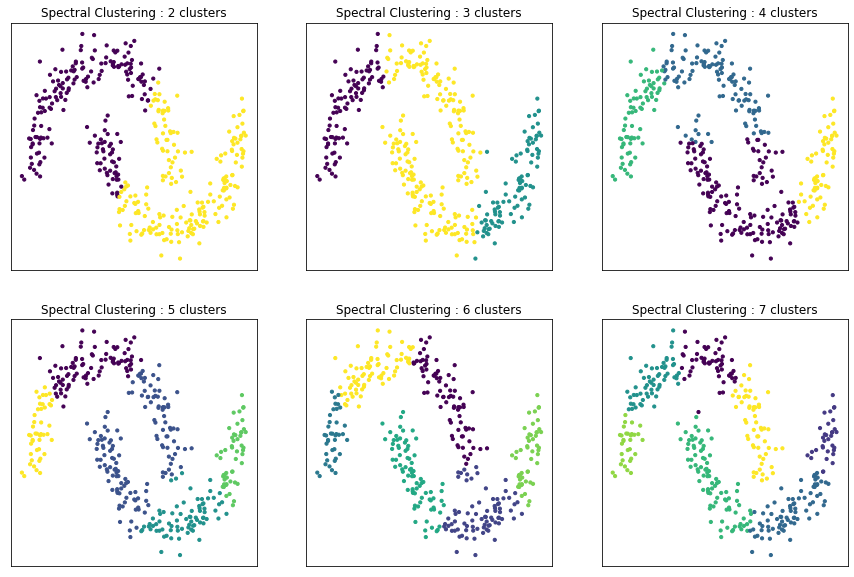

In [157]:
# Algorithms to compare
n_clusters_list = [2, 3, 4, 5, 6, 7]
random_state = None
n_init = 10
gamma = 1.0
affinity = 'rbf'
degree = 3
coef0 = 1
clustering_algorithms = {
    "Spectral Clustering": SpectralClustering,
}

# Calculate the number of rows needed for the subplots
num_rows = len(n_clusters_list) // 3 + (len(n_clusters_list) % 3 > 0)

# Make subplots with 3 graphs per line
fig, axs = plt.subplots(
    num_rows, 3, figsize=(15, 5 * num_rows)
)

for i, (algorithm_name, Algorithm) in enumerate(clustering_algorithms.items()):
    for j, n_clusters in enumerate(n_clusters_list):
        spectral_clustering = Algorithm(
            n_clusters=n_clusters,
            random_state=random_state,
            n_init=n_init,
            gamma=gamma,
            affinity=affinity,
            degree=degree,
            coef0=coef0
        )
        spectral_clustering.fit(X)

        row = j // 3
        col = j % 3

        axs[row, col].scatter(X[:, 0], X[:, 1], s=10, c=spectral_clustering.labels_)

        axs[row, col].set_title(f"{algorithm_name} : {n_clusters} clusters")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


## 3.6 DBSCAN

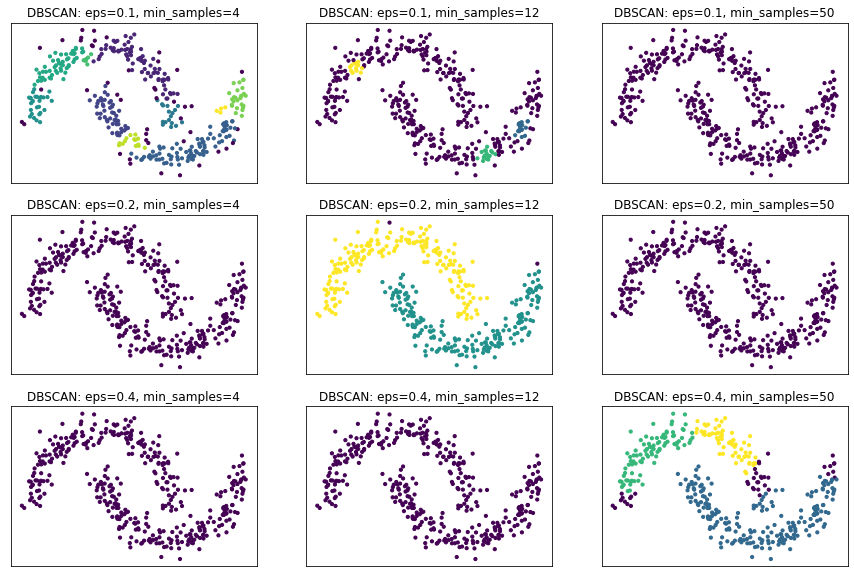

In [158]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Parameters to vary
eps_values = [0.1, 0.2, 0.4]
min_samples_values = [4, 12, 50]

# Create a grid of subplots
fig, axs = plt.subplots(len(eps_values), len(min_samples_values), figsize=(15, 10))

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(X)

        axs[i, j].scatter(X[:, 0], X[:, 1], s=10, c=dbscan.labels_, cmap='viridis')
        axs[i, j].set_title(f"DBSCAN: eps={eps}, min_samples={min_samples}")

# Set common labels and hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


# 4. Etude de la robustesse par rapport aux exceptions

#### Explications des experimentations du 4:

On a fait varier l'ordonnée de l'exception avec un facteur alpha. Le but est de voir comment se comporte les algorithmes c-moyennes floues et c-moyennes floues possibilistes, ainsi que GMM lorsque l'ordonnée de l'exception varie.

Pour voir de facon plus clair l'impacte de la modification de l'ordonnée de l'exception, on a mis 150 points exactement sur les coordonnées de l'exception afin de donner artificiellement plus de poids a cette exception.

On a observé que entre l'algorithme c-moyennes floues et l'algorithme c-moyennes floues possibilistes, l'algorithme c-moyennes floues possibiliste est plus robuste aux outliers.
C-moyennes floues fait face des problèmes dans le cas de données bruitées ou d’exceptions, comme dans ces experimentations. En effet il existe une distorsion des centres qui sont attirés par les exceptions.
Comme vue en cours, l'algorithme c-moyennes floues possibiliste récompense les degrés d’appartenance élevés et évite la solution triviale. Avec c-moyennes possibilistes, on voit que les lignes de niveaux sont plus resserrées vers le centre du cluster, et le centre n'est pas attiré par l'exception avant que celui-ci ne se rapproche significativement du centre du cluster (pour alpha = 4). 

On a observé aussi que l'algorithme GMM est plutot sensible aux outliers, comme c-moyennes floues.

Generation de 2 clusters spheriques et une exception situee a egale distance des 2 clusters:

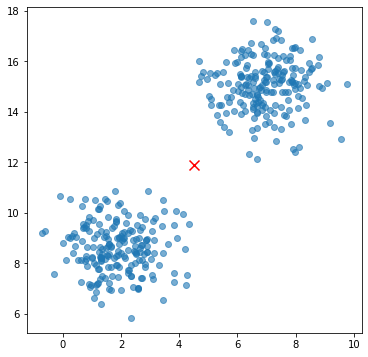

In [159]:
# Generation de 2 clusters spheriques et une exception situee a egale distance des 2 clusters:
np.random.seed(0)
X_cluster, y_cluster, centers_cluster = generate_spheres(2, 200, 2, 20)

# Calculate the midpoint between the centers of the clusters
midpoint = np.mean(centers_cluster, axis=0)

X_cluster = np.vstack((X_cluster, midpoint))
y_cluster = np.hstack((y_cluster, 2))

plt.figure(figsize=(6, 6))
plt.scatter(X_cluster[:-1,0],X_cluster[:-1,1] ,alpha=0.6)
plt.scatter(X_cluster[-1,0],X_cluster[-1,1] ,color='red', marker='x', s=100)
plt.show()

## 4.1 Algorithme c-moyennes floues

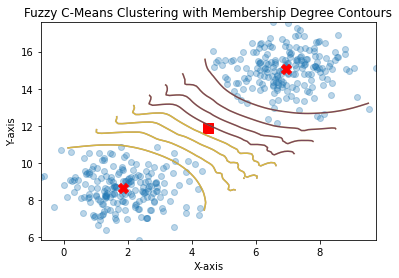

In [160]:
# Paramètres de l'algorithme fuzzy c-means
nb_iter = 10
m = 2
nb_clusters = 2

W, U = c_moyenne_floue(X_cluster, nb_clusters, nb_iter, m)

# Affichage des contours et des centres obtenus
plot_fuzzy_cmeans_contours(X_cluster, W, U)

# Affichage du point exception
plt.scatter(midpoint[0], midpoint[1], color='red', marker='s', s=100)

plt.show()

Nous faisons varier ci-dessous l'ordonnée de l'exception avec un facteur alpha. Le but est de voir comment se comporte l'algorithme c-moyennes floues lorsque l'ordonnée de l'exception varie.

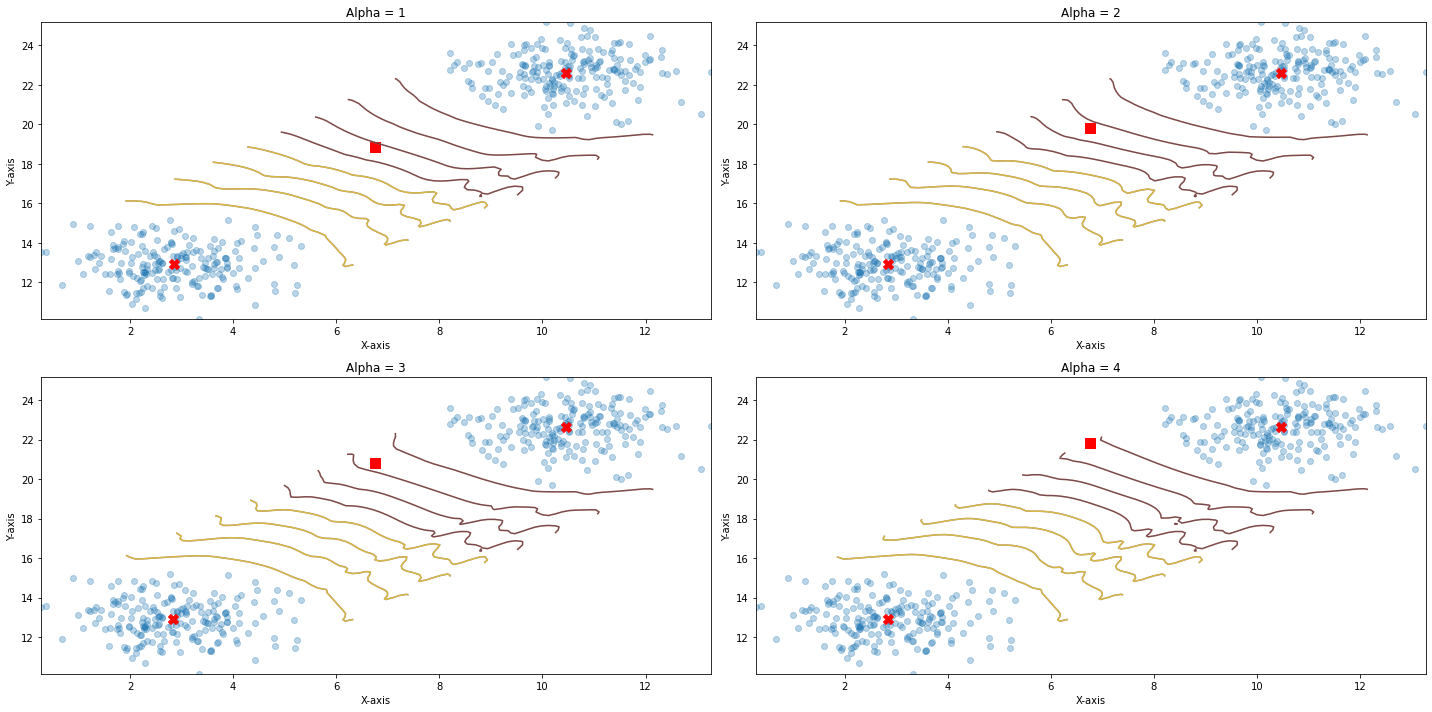

In [161]:
plt.figure(figsize=(20, 10))

for i in range(4):
    np.random.seed(0)
    alpha = 1 * (i + 1)
    
    # Generate 2 spherical clusters and a point located at an equal distance from the 2 clusters
    X_cluster, y_cluster, centers_cluster = generate_spheres(2, 200, 2, 30)

    # Calculate the midpoint between the centers of the clusters
    midpoint = np.mean(centers_cluster, axis=0)
    midpoint[1] += alpha

    X_cluster = np.vstack((X_cluster, midpoint))
    y_cluster = np.hstack((y_cluster, 2))

    # Apply fuzzy c-means
    nb_iter = 10
    m = 2
    nb_clusters = 2

    W, U = c_moyenne_floue(X_cluster, nb_clusters, nb_iter, m)

    # Affichage des contours et des centres obtenus
    plt.subplot(2, 2, i + 1)
    plot_fuzzy_cmeans_contours(X_cluster, W, U)

    # Affichage du point exception
    plt.scatter(midpoint[0], midpoint[1], color='red', marker='s', s=100)
    
    plt.title(f'Alpha = {alpha}')

plt.tight_layout()
plt.show()

Ci-dessous, nous avons recommencé l'experience mais en mettant 150 points exactement sur les coordonnées de l'exception afin de donner artificiellement plus de poids a cette exception. Le nombre de données situées autour de l'exception est donc plus important.

On observe ainsi plus de changements, que ca soit dans les lignes de niveaux ou dans les centres des clusters (notamment le cluster auquel l'exception appartient).

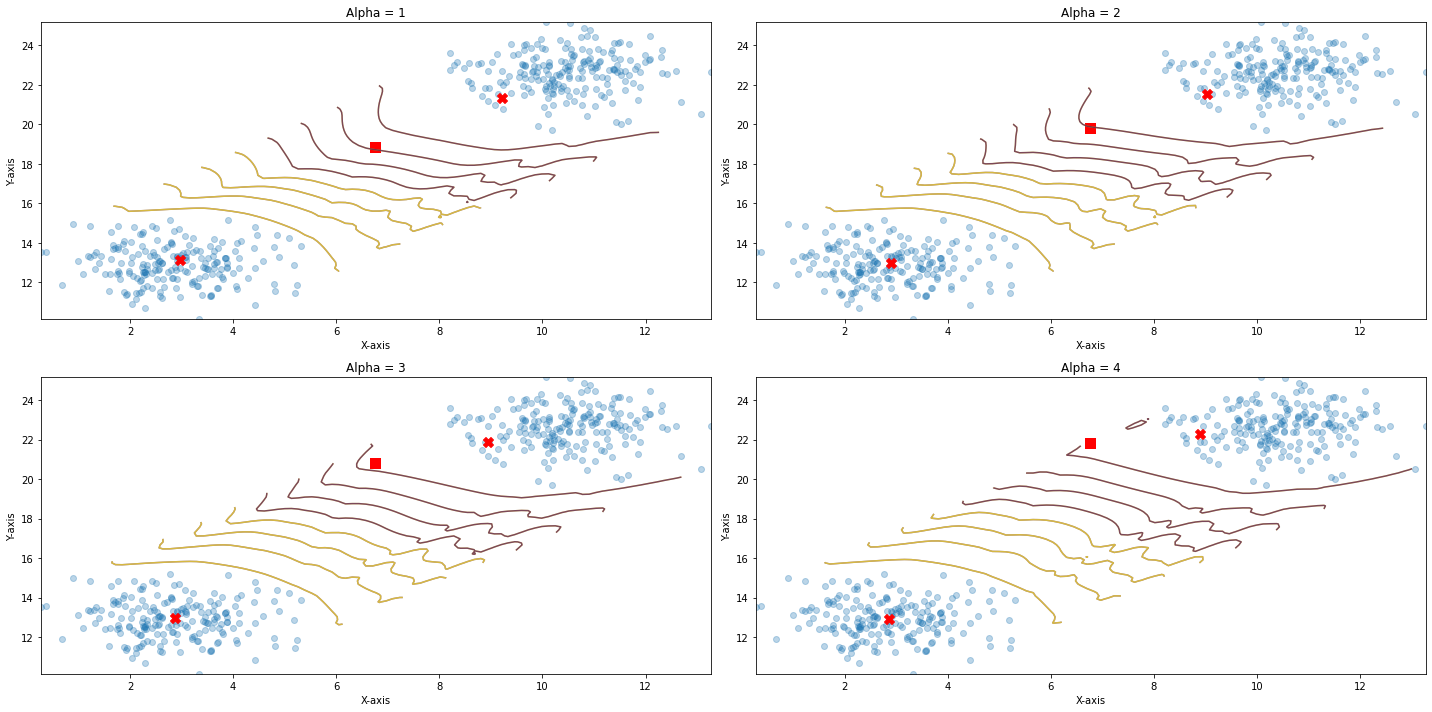

In [162]:
plt.figure(figsize=(20, 10))

for i in range(4):
    np.random.seed(0)
    alpha = 1 * (i + 1)
    
    # Generate 2 spherical clusters and a point located at an equal distance from the 2 clusters
    X_cluster, y_cluster, centers_cluster = generate_spheres(2, 200, 2, 30)

    # Calculate the midpoint between the centers of the clusters
    midpoint = np.mean(centers_cluster, axis=0)*np.ones((150,2))
    midpoint[:,1] += alpha

    X_cluster = np.vstack((X_cluster, midpoint))
    y_cluster = np.hstack((y_cluster, 2))

    # Apply fuzzy c-means
    nb_iter = 10
    m = 2
    nb_clusters = 2

    W, U = c_moyenne_floue(X_cluster, nb_clusters, nb_iter, m)

    # Affichage des contours et des centres obtenus
    plt.subplot(2, 2, i + 1)
    plot_fuzzy_cmeans_contours(X_cluster, W, U)

    # Affichage du point exception
    plt.scatter(midpoint[:,0], midpoint[:,1], color='red', marker='s', s=100)
    
    plt.title(f'Alpha = {alpha}')

plt.tight_layout()
plt.show()

## 4.2 Algorithme c-moyennes floues possibilistes

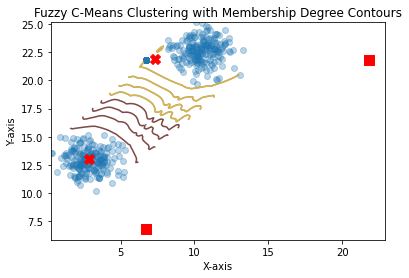

In [163]:
# Paramètres de l'algorithme fuzzy c-means
nb_iter = 10
m = 2
nb_clusters= 2


# Application de l'algorithme fuzzy c-means
eta = np.ones((nb_clusters))*2.5
W1,U1 = c_moyenne_floue(X_cluster, nb_clusters, nb_iter = 100, m=2)

# Apply fuzzy k-means
W, U = pcm(X_cluster,W=W1, nb_clusters=nb_clusters, eta=eta)\

# Affichage des contours et des centres obtenus
plot_fuzzy_cmeans_contours(X_cluster, W1, U1)

# Affichage du point exception
plt.scatter(midpoint[0], midpoint[1], color='red', marker='s', s=100)

plt.show()

Nous faisons varier ci-dessous l'ordonnée de l'exception avec un facteur alpha. Le but est de voir comment se comporte l'algorithme c-moyennes floues possibiliste lorsque l'ordonnée de l'exception varie.

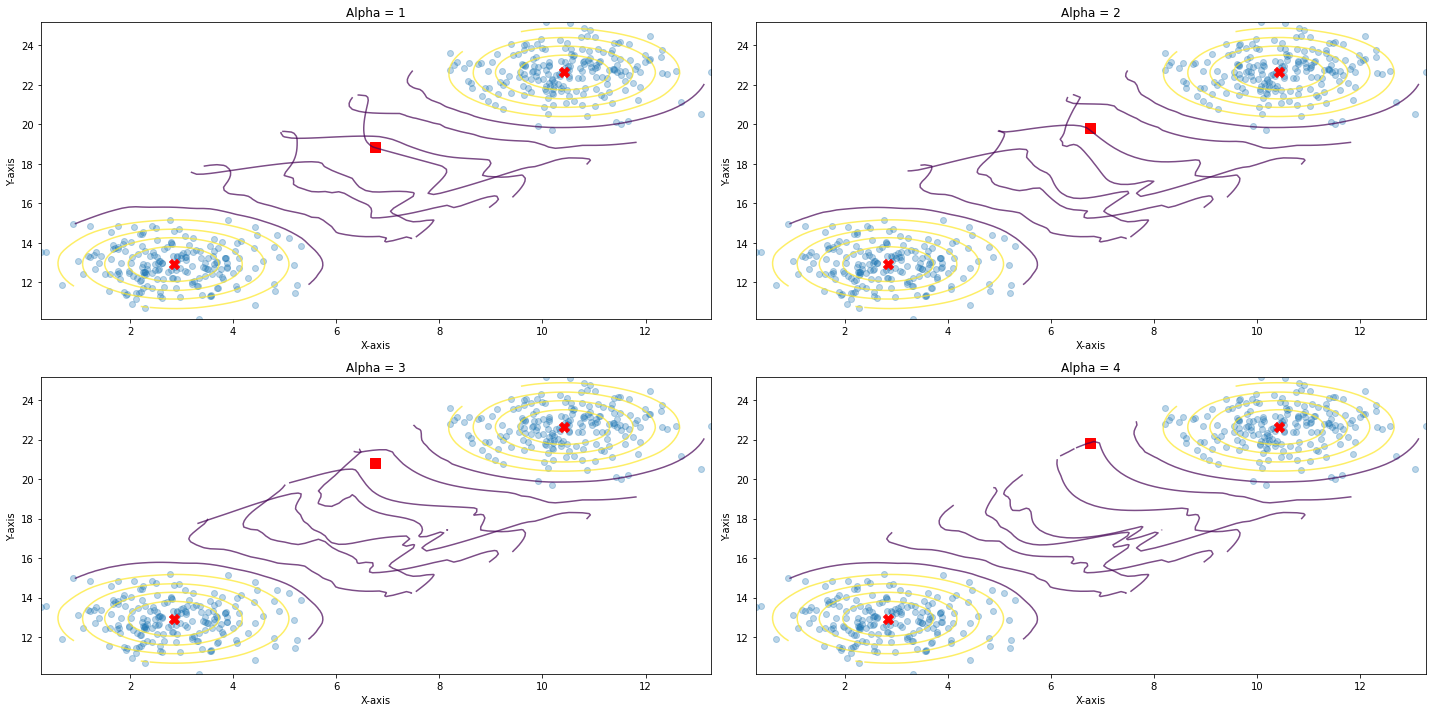

In [164]:
plt.figure(figsize=(20, 10))

for i in range(4):
    np.random.seed(0)
    alpha = 1 * (i + 1)
    
    # Generate 2 spherical clusters and a point located at an equal distance from the 2 clusters
    X_cluster, y_cluster, centers_cluster = generate_spheres(2, 200, 2, 30)

    # Calculate the midpoint between the centers of the clusters
    midpoint = np.mean(centers_cluster, axis=0)
    midpoint[1] += alpha

    X_cluster = np.vstack((X_cluster, midpoint))
    y_cluster = np.hstack((y_cluster, 2))

    # Apply fuzzy c-means
    nb_iter = 10
    m = 2
    nb_clusters = 2


    eta = np.ones((nb_clusters))*2.5
    W1,U1 = c_moyenne_floue(X_cluster, nb_clusters, nb_iter = 100, m=2)

    # Apply fuzzy k-means
    W, U = pcm(X_cluster,W=W1, nb_clusters=nb_clusters, eta=eta)

    # Affichage des contours et des centres obtenus
    plt.subplot(2, 2, i + 1)
    plot_fuzzy_cmeans_contours(X_cluster, W, U)

    # Affichage du point exception
    plt.scatter(midpoint[0], midpoint[1], color='red', marker='s', s=100)
    
    plt.title(f'Alpha = {alpha}')

plt.tight_layout()
plt.show()

Ci-dessous, nous avons recommencé l'experience mais en mettant 150 points exactement sur les coordonnées de l'exception afin de donner artificiellement plus de poids a cette exception. Le nombre de données situées autour de l'exception est donc plus important.

On observe ainsi plus de changements, que ca soit dans les lignes de niveaux ou dans les centres des clusters (notamment le cluster auquel l'exception appartient).

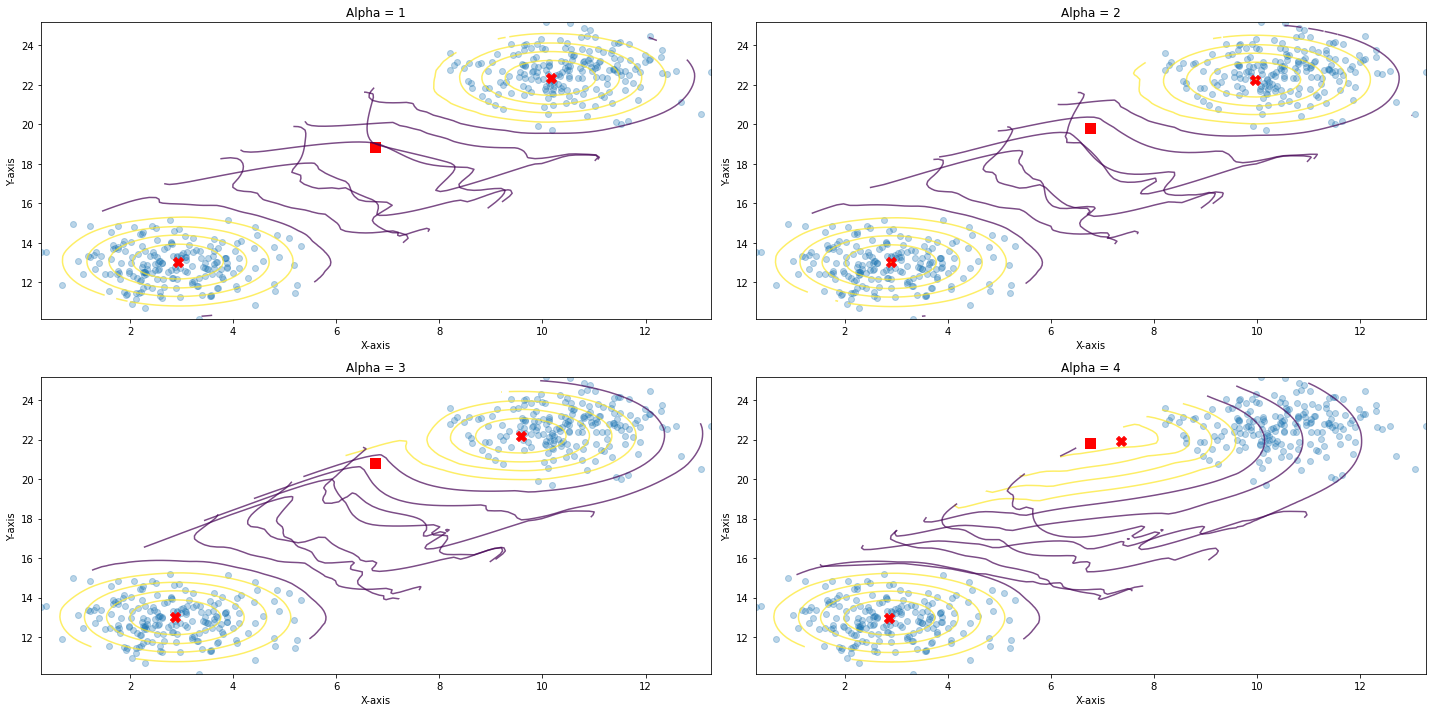

In [165]:
plt.figure(figsize=(20, 10))

for i in range(4):
    np.random.seed(0)
    alpha = 1 * (i + 1)
    
    # Generate 2 spherical clusters and a point located at an equal distance from the 2 clusters
    X_cluster, y_cluster, centers_cluster = generate_spheres(2, 200, 2, 30)

    # Calculate the midpoint between the centers of the clusters
    midpoint = np.mean(centers_cluster, axis=0)*np.ones((150,2))
    midpoint[:,1] += alpha

    X_cluster = np.vstack((X_cluster, midpoint))
    y_cluster = np.hstack((y_cluster, 2))

    # Apply fuzzy c-means
    nb_iter = 10
    m = 2
    nb_clusters = 2

    eta = np.ones((nb_clusters))*2.5
    W1,U1 = c_moyenne_floue(X_cluster, nb_clusters, nb_iter = 100, m=2)

    # Apply fuzzy k-means
    W, U = pcm(X_cluster,W=W1, nb_clusters=nb_clusters, eta=eta)

    # Affichage des contours et des centres obtenus
    plt.subplot(2, 2, i + 1)
    plot_fuzzy_cmeans_contours(X_cluster, W, U)

    # Affichage du point exception
    plt.scatter(midpoint[:,0], midpoint[:,1], color='red', marker='s', s=100)
    
    plt.title(f'Alpha = {alpha}')

plt.tight_layout()
plt.show()

## 4.3 Algorithme GMM

Nous faisons varier ci-dessous l'ordonnée de l'exception avec un facteur alpha. Le but est de voir comment se comporte l'algorithme GMM lorsque l'ordonnée de l'exception varie.

In [166]:
plt.figure(figsize=(20, 10))

for i in range(4):
    np.random.seed(0)
    alpha = 1 * (i + 1)
    
    # Generate 2 spherical clusters and a point located at an equal distance from the 2 clusters
    X_cluster, y_cluster, centers_cluster = generate_spheres(2, 200, 2, 30)

    # Calculate the midpoint between the centers of the clusters
    midpoint = np.mean(centers_cluster, axis=0)*np.ones((1,2))
    midpoint[:,1] += alpha

    X_cluster = np.vstack((X_cluster, midpoint))
    y_cluster = np.hstack((y_cluster, 2))

    # Apply GMM
    n = 2
    random_state = 0
    clustering_algorithms = {
        "Gaussian Mixture": GaussianMixture,
    }

    gm = Algorithm(n_components=n, n_init=10, max_iter=100, tol=0.0001)
    gm.fit(X_cluster)
    means = gm.means_

    
    # Affichage des contours et des centres obtenus
    plt.subplot(2, 2, i + 1)
    plot_gmm_clusters_with_contours(gm, X_cluster)

    # Affichage du point exception
    plt.scatter(midpoint[:,0], midpoint[:,1], color='red', marker='s', s=100)
    
    plt.title(f'Alpha = {alpha}')

plt.tight_layout()
plt.show()

TypeError: SpectralClustering.__init__() got an unexpected keyword argument 'max_iter'

<Figure size 1440x720 with 0 Axes>

Ci-dessous, nous avons recommencé l'experience mais en mettant 150 points exactement sur les coordonnées de l'exception afin de donner artificiellement plus de poids a cette exception. Le nombre de données situées autour de l'exception est donc plus important.

On observe ainsi plus de changements, que ca soit dans les lignes de niveaux ou dans les centres des clusters (notamment le cluster auquel l'exception appartient).

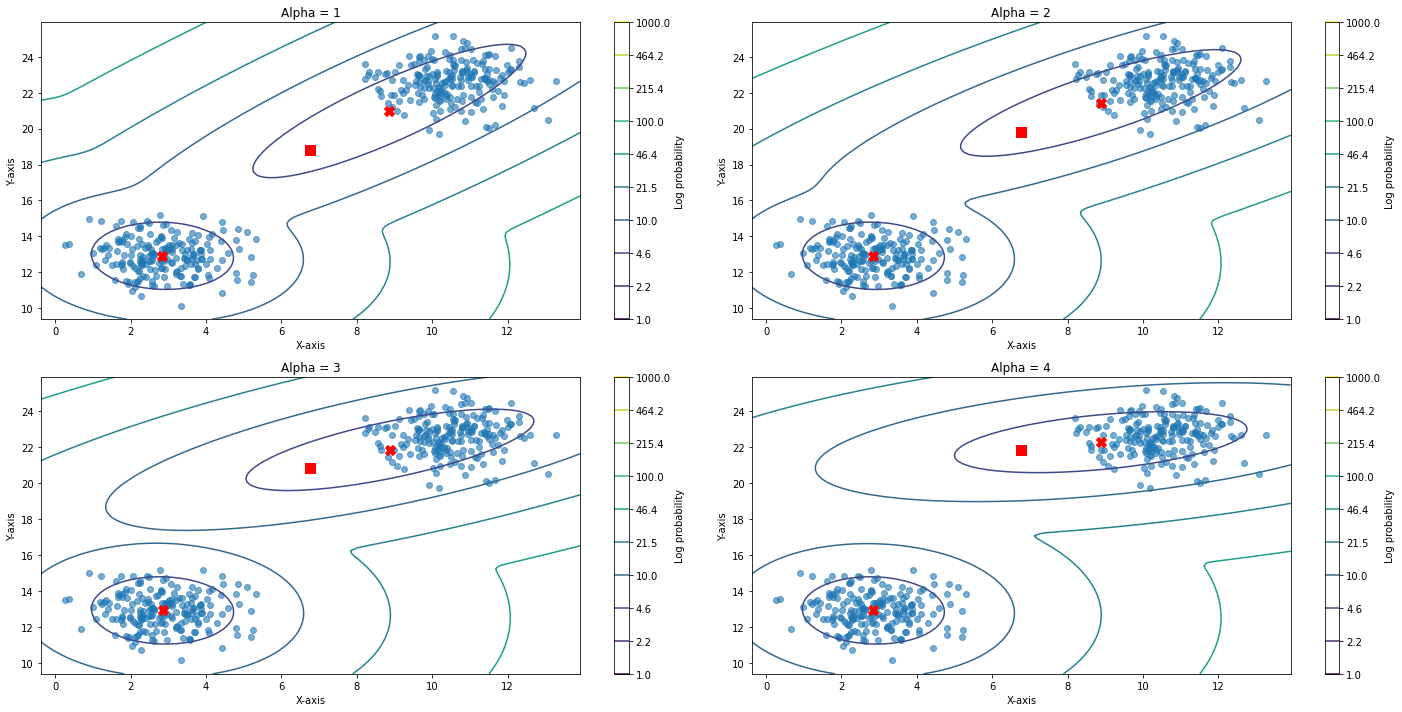

In [ ]:
plt.figure(figsize=(20, 10))

for i in range(4):
    np.random.seed(0)
    alpha = 1 * (i + 1)
    
    # Generate 2 spherical clusters and a point located at an equal distance from the 2 clusters
    X_cluster, y_cluster, centers_cluster = generate_spheres(2, 200, 2, 30)

    # Calculate the midpoint between the centers of the clusters
    midpoint = np.mean(centers_cluster, axis=0)*np.ones((150,2))
    midpoint[:,1] += alpha

    X_cluster = np.vstack((X_cluster, midpoint))
    y_cluster = np.hstack((y_cluster, 2))

    # Apply GMM
    n = 2
    random_state = 0
    clustering_algorithms = {
        "Gaussian Mixture": GaussianMixture,
    }

    gm = Algorithm(n_components=n, n_init=10, max_iter=100, tol=0.0001)
    gm.fit(X_cluster)
    means = gm.means_

    
    # Affichage des contours et des centres obtenus
    plt.subplot(2, 2, i + 1)
    plot_gmm_clusters_with_contours(gm, X_cluster)

    # Affichage du point exception
    plt.scatter(midpoint[:,0], midpoint[:,1], color='red', marker='s', s=100)
    
    plt.title(f'Alpha = {alpha}')

plt.tight_layout()
plt.show()

# 5. Stabilité des algorithmes

## Explication : 

Nous avons étudié la stabilité des algoritmes C moyenne floue (CM), C moyenne floue possibiliste (PCM)  et Gaussian mixture model (GMM) à différentes initialisation. 
Les données générées sont issues 4 gaussiennes bidimensionnelles de centre aléatoire.
On peut voir que l'algorithme le plus stable par rapport aux différentes initialisations est GMM puis CM pui enfin PCM. 

Pour PCM afin de mieux observer l'effet de l'initialisation nous l'avons utilisé en récupérant les centroides W après un CM et aussi en initialisant les centroides W aléatoirement. 
On peut voir que celui ci est moins stable lorsque l'il est utilisé directement sans initialiser les centroides avec un CM clustering ce qui illustre le propos du cours (diapo 26) 



C-moyenne floue

In [ ]:
def plot_contours(X, W, U, figsize=(8, 8), resolution=100):

    # Create a meshgrid for the contour plots
    x_min, y_min = np.min(X, axis=0)
    x_max, y_max = np.max(X, axis=0)
    x = np.linspace(x_min, x_max, resolution)
    y = np.linspace(y_min, y_max, resolution)
    X_mesh, Y_mesh = np.meshgrid(x, y)

    # Create a custom colormap
    cmap = ListedColormap(plt.cm.viridis(np.linspace(0, 1, W.shape[0])))

    # Plot contours for each cluster
    for j in range(W.shape[0]):
        # Interpolate membership degrees for cluster j
        Z = griddata(X, U[:, j], (X_mesh, Y_mesh), method='cubic')

        # Plot the membership degree contours for cluster j
        contour = plt.contour(X_mesh, Y_mesh, Z, levels=np.linspace(0, 1, 10), cmap=cmap, alpha=0.7)

    # Plot the data points and the centroids
    plt.scatter(X[:, 0], X[:, 1], alpha =0.3)
    plt.scatter(W[:, 0], W[:, 1], c='red', s=100, marker='X')

    # Labeling the plot
    plt.title("Contours")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")

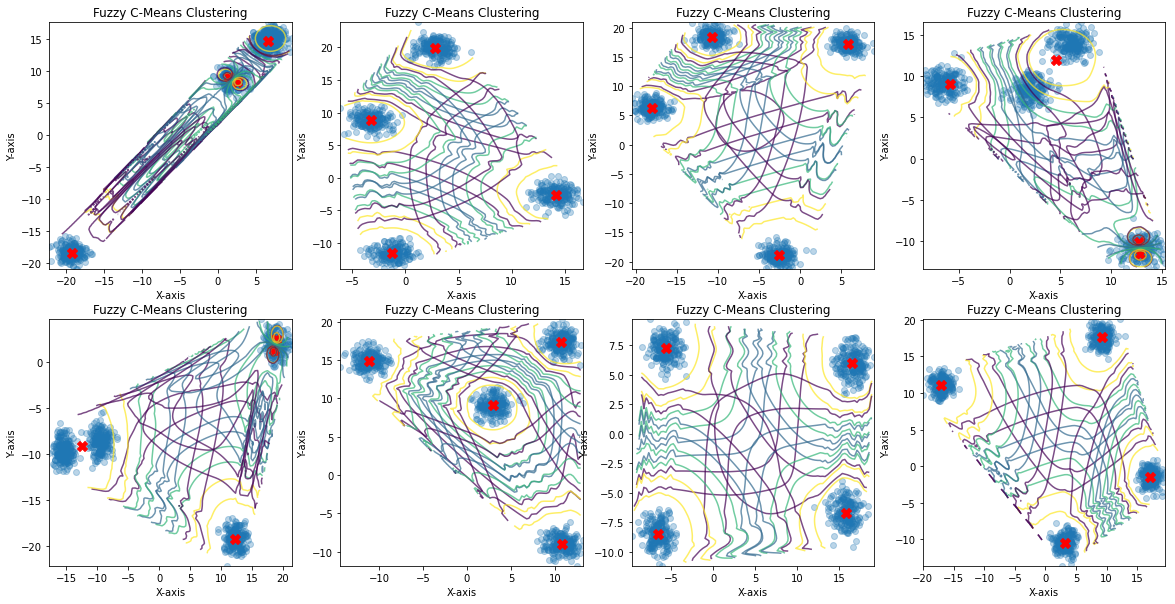

In [ ]:
nb_iter = 10
m = 2
nb_clusters= 4
plt.figure(figsize=(20, 10))

for i in range(8):
    np.random.seed(i)
    X, y, centers = generate_spheres(4, 200, 2, 20)
    W, U = c_moyenne_floue(X, nb_clusters, nb_iter, m)

    # Affichage des contours et des centres obtenus
    plt.subplot(2, 4, i+1)
    plot_contours(X, W, U)
    plt.title("Fuzzy C-Means Clustering")

plt.show()

Possibilistic fuzzy C mean with W initialisation following a Fuzzy C mean

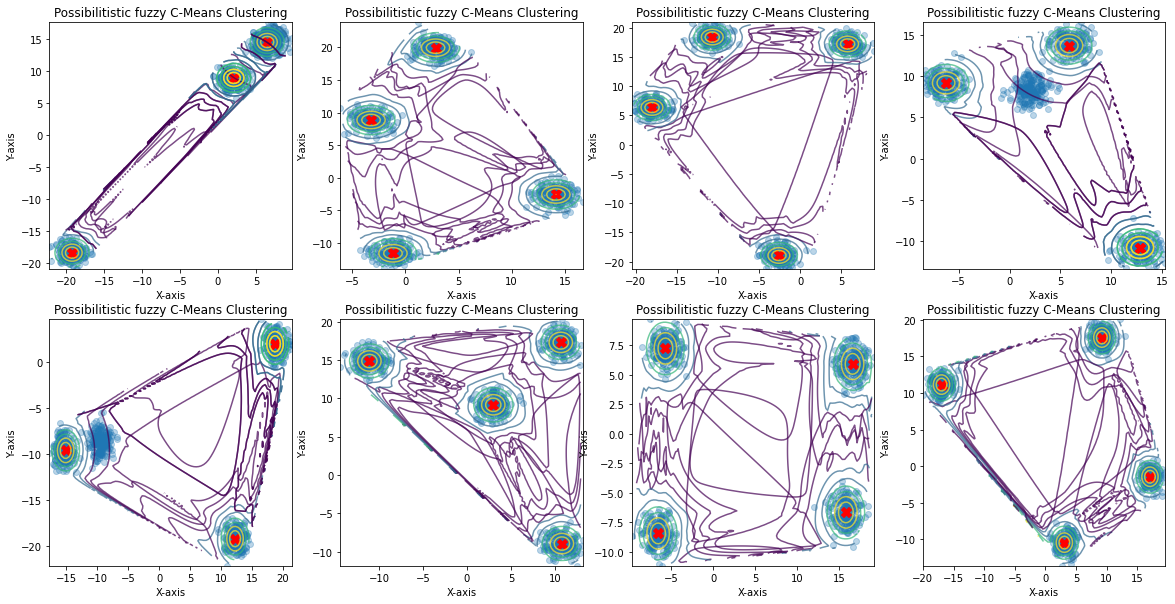

In [ ]:
nb_iter = 10
m = 2
nb_clusters= 4
plt.figure(figsize=(20, 10))
for i in range(8):
    np.random.seed(i)
    X, y, centers = generate_spheres(4, 200, 2, 20)
    eta = np.ones((nb_clusters))*2.5
    W1,U1 = c_moyenne_floue(X, nb_clusters, nb_iter = 10, m=2)
    W, U = pcm(X,W=W1, nb_clusters=nb_clusters, eta=eta)

    # Affichage des contours et des centres obtenus
    plt.subplot(2, 4, i+1)
    plot_contours(X, W, U)
    plt.title("Possibilitistic fuzzy C-Means Clustering")

plt.show()

Possibilistic fuzzy C mean with random initialization of the centers

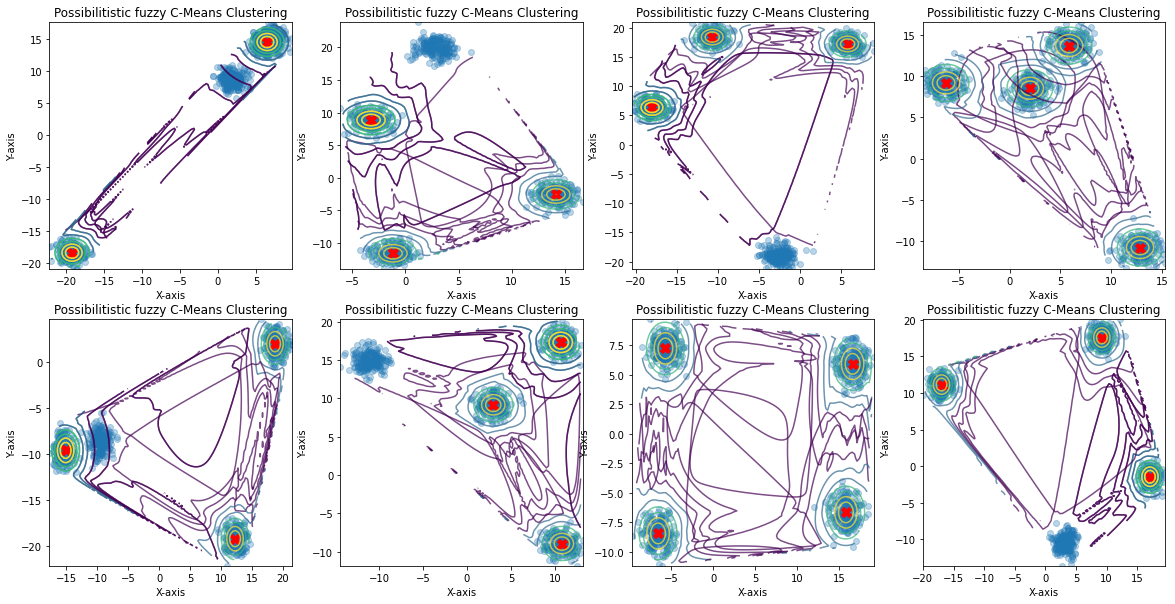

In [ ]:
nb_iter = 10
m = 2

nb_clusters= 4
plt.figure(figsize=(20, 10))
for i in range(8):
    np.random.seed(i)
    X, y, centers = generate_spheres(4, 200, 2, 20)
    eta = np.ones((nb_clusters))*2.5
    W, U = pcm(X, nb_clusters=nb_clusters, eta=eta)

    # Affichage des contours et des centres obtenus
    plt.subplot(2, 4, i+1)
    plot_contours(X, W, U)
    plt.title("Possibilitistic fuzzy C-Means Clustering")

plt.show()

GMM

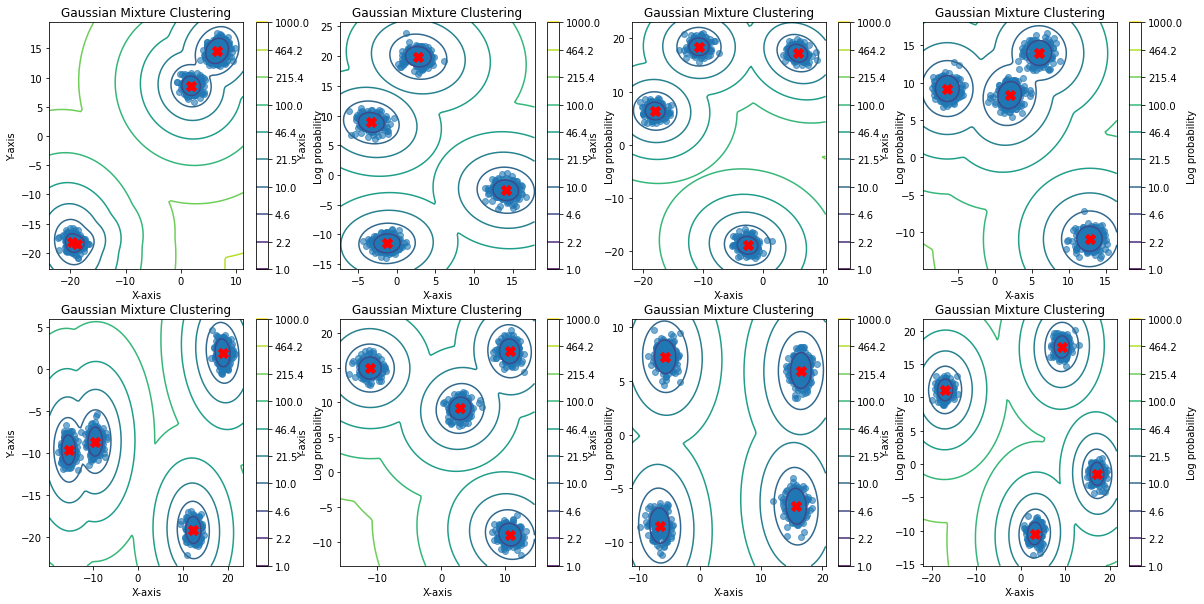

In [ ]:
n= 4
random_state = 0
clustering_algorithms = {
    "Gaussian Mixture": GaussianMixture,
}

plt.figure(figsize=(20, 10))
for i, (algorithm_name, Algorithm) in enumerate(clustering_algorithms.items()):
    for i in range(8):
        np.random.seed(i)
        X, y, centers = generate_spheres(4, 200, 2, 20)
        gm = Algorithm(n_components=n, n_init=10, max_iter=100, tol=0.0001, random_state=random_state)
        gm.fit(X)
        means = gm.means_

        # Plot the contours
        plt.subplot(2, 4, i+1)
        plot_gmm_clusters_with_contours(gm, X)
        plt.title("Gaussian Mixture Clustering")
